In [1]:
# Checks if the code is in a colab notebook

try:
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False

Run on Colab notebook

In [2]:
if IN_COLAB:
  !pip install basicsr
  drive.mount('/content/drive/')
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_HR.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_valid_LR_clean.zip
  !unzip /content/drive/MyDrive/Datasets/DIV2K_train_LR_clean.zip
  #!unzip /content/drive/MyDrive/Datasets/DIV2K_train_HR.zip
  !unzip /content/drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/gen_images_0.zip
  FOLDER_LR_TEST = 'DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'DIV2K_train_LR_clean'
  #FOLDER_HR_TRAIN = 'DIV2K_train_HR'
  FOLDER_GEN_IMAGES = 'gen_images_0'

  STUDENT_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.pth'
  STUDENT_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/student.csv'
  GENERATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.pth'
  GENERATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/Models/generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.pth'
  DISCRIMINATOR_RECORDS_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/Pruning/80_percent/discriminator.csv'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'

  TEACHER_MODEL_PATH = 'drive/MyDrive/ML/Indiv_Project/Second_Year/KD/ESRGAN_models/RealESRGAN_x4plus.pth'

Run on my Windows desktop

In [3]:
if not IN_COLAB:
  FOLDER_LR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_LR_clean'
  FOLDER_HR_TEST = 'D:\Downloads\Div2k\DIV2K_valid_HR'
  FOLDER_LR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_LR_clean'
  FOLDER_HR_TRAIN = 'D:\Downloads\Div2k\DIV2K_train_HR'
  
  STUDENT_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.pth'
  STUDENT_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\student.csv'
  GENERATOR_MODEL_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.pth'
  GENERATOR_RECORDS_PATH='D:\oldDrive\ML\Indiv_Project\Second_Year\KD\Models\generator.csv'
  DISCRIMINATOR_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.pth'
  DISCRIMINATOR_MODEL_PATH_24 = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator_24.pth'
  DISCRIMINATOR_RECORDS_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\discriminator.csv'
  FOLDER_GEN_IMAGES = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\gen_images_0'
  
  PRUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son.pth'
  FINE_TUNED_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\Pruning\80_percent\son_fine.pth'
  
  TEACHER_MODEL_PATH = 'D:\oldDrive\ML\Indiv_Project\Second_Year\KD\ESRGAN_models\RealESRGAN_x4plus.pth'

# Setup

In [4]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import cv2
import csv
import math
import numpy as np
import os
import queue
import threading
from basicsr.archs.rrdbnet_arch import RRDBNet
import torchvision
from os import listdir, environ, path
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import vgg19

# Making sure to use the gpu, if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# torch.cuda.set_device(torch.device(0))

C:\Users\Vincent\anaconda3\envs\ai-robotics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels: int, out_channels: int, kernel_size: int, use_act: bool, **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
    self.activation = nn.LeakyReLU(.2, inplace=True) if use_act else nn.Identity()

  def forward(self, x):
    return self.activation(self.conv(x))

class RDB(nn.Module):
  def __init__(self, in_channels, middle_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.block = nn.ModuleList([ConvBlock(in_channels + i * middle_channels,
                                  middle_channels if i<4 else in_channels,
                                  3,
                                  stride=1,
                                  padding=1,
                                  use_act=i<4) for i in range(5)])


  def forward(self, x):
    input = x
    for conv in self.block:
      out = conv(input)
      input = torch.cat([input, out], dim=1)
    return self.residual_scale * out + x

class RRDB(nn.Module):
  def __init__(self, in_channels, mid_channels = 32, residual_scale = .2):
    super().__init__()
    self.residual_scale = residual_scale
    self.model = nn.Sequential(*[RDB(in_channels, middle_channels = mid_channels, residual_scale = residual_scale) for _ in range(3)])
  
  def forward(self, x):
    return self.model(x) * self.residual_scale + x

class Head(nn.Module):
  def __init__(self, out_channels = 64) -> None:
    super().__init__()
    self.model = nn.Conv2d(3, out_channels, 3, stride=1, padding=1)

  def forward(self, x):
    return self.model(x)

class Tail(nn.Module):
  def __init__(self, in_channels = 64) -> None:
    super().__init__()
    self.model = nn.Sequential(nn.Conv2d(in_channels, 256, 3, stride=1, padding=1),
                               nn.Upsample(scale_factor=4, mode='nearest'),
                               nn.LeakyReLU(.2, inplace=True),
                               nn.Conv2d(256, 3, 3, stride=1, padding=1))
  
  def forward(self, x):
    return self.model(x)

# Original code for ESRGAN:
# https://github.com/xinntao/ESRGAN/blob/master/RRDBNet_arch.py

import functools
import torch
import torch.nn as nn
import torch.nn.functional as F


def make_layer(block, n_layers, **kwargs):
    layers = []
    for _ in range(n_layers):
        layers.append(block(**kwargs))
    return nn.Sequential(*layers)


class ResidualDenseBlock_5C(nn.Module):
    def __init__(self, nf=64, gc=32, bias=True):
        super(ResidualDenseBlock_5C, self).__init__()
        # gc: growth channel, i.e. intermediate channels
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1, bias=bias)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1, bias=bias)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1, bias=bias)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1, bias=bias)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1, bias=bias)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        # mutil.initialize_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x


class RRDB(nn.Module):
    '''Residual in Residual Dense Block'''

    def __init__(self, nf, gc=32):
        super(RRDB, self).__init__()
        self.RDB1 = ResidualDenseBlock_5C(nf, gc)
        self.RDB2 = ResidualDenseBlock_5C(nf, gc)
        self.RDB3 = ResidualDenseBlock_5C(nf, gc)

    def forward(self, x):
        out = self.RDB1(x)
        out = self.RDB2(out)
        out = self.RDB3(out)
        return out * 0.2 + x


class RRDBNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32):
        super(RRDBNet, self).__init__()

        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1, bias=True)
        self.RRDB_trunk = make_layer(RRDB, nb, nf=nf, gc=gc)
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        #### upsampling
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.HRconv = nn.Conv2d(nf, nf, 3, 1, 1, bias=True)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1, bias=True)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        feat = self.conv_first(x)
        trunk = self.trunk_conv(self.RRDB_trunk(feat))
        feat = feat + trunk

        feat = self.lrelu(self.upconv1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.upconv2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.HRconv(feat)))

        return out

In [6]:
class DIV2KEval(object):
    def __init__(self, folder, res_size: int = 48):
        self.folder = folder
        self.image_names = sorted(listdir(folder))
        self.len = len(self.image_names)
        self.resize = torchvision.transforms.Resize(res_size)
        
    def get_image(self, index: int):
        image = Image.open(Path(self.folder).joinpath(self.image_names[index]))
        return torchvision.transforms.ToTensor()(image)
    
    def __getitem__(self, index: int):
        # Get the right target image because we will use it resized version as input for the model
        image = self.get_image(index)
        return (self.resize(image),)
    
    def __len__(self):
        return self.len

    def restrict_size(self, size):
        if size < len(self.image_names) and size > 0:
            self.len = size
        else:
            self.len = len(self.image_names)
            print(f"Size must be between 0 and {len(self.image_names)}")

class DIV2KTrain(DIV2KEval):
    def __init__(self,  high_res_folder, low_res_size: int = 48, hr_resize_factor = 3):
        # We setup the HR folder and and (possible) resize as the basis for the parent class
        #
        # smallest dim: ~600 - We don't want to resize over 648 pixels because the smallest dimension of our
        # training HR images is 648px. We don't want the target image to have experienced any kind of super-resolution.
        crop_size = low_res_size*4
        
        # hr_target_size
        super().__init__(high_res_folder, int(crop_size * hr_resize_factor))
        
        self.crop_size = crop_size
        
        # smallest dim:: 48
        self.resize_lr = torchvision.transforms.Resize(low_res_size)

  
    def __getitem__(self, i):
        # Get the right target image because we will use it resized version as input for the model
        target = self.get_image(i)

        # The images having a resolution of 2040 pixels make it hard for our cropping of 48*4=192 pixels
        # to mimic a genuine image despite its advantage of showing great detailing.
        # Mainly because we only use a very small area of the image:
        #     (192*192)/(2040*1300) = 2%, in the case of an image with a smaller dimension of 1300 pixels.
        # This is why we introduce croppings of resized images that will capture more the elements of the HR image.
        #     (192*192)/(582*371) = 17%, if we divide the original proportions by 3.5
        # However, there is still a compromise between the loss of information induced when resizing the HR image down
        # and the amount of elements we retain when cropping the original image.
        # Hence why we use multiple scales when extracting these croppins.

        # This probablity is prone to decrease as the model gains more performance (with smaller learning rate)
        if torch.rand(1).item() < .99:
            # Resize the full image
            target = self.resize(target)

        # Crop of target image
        x, y, h, w = torchvision.transforms.RandomCrop.get_params(target, output_size=(self.crop_size, self.crop_size))
        target = torchvision.transforms.functional.crop(target, x, y, h, w)

        # Resizing for input image
        img = self.resize_lr(target)

        return img, target


In [7]:
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.L1Loss()
        self.vgg = vgg19(weights='DEFAULT').features[:35].eval().to(DEVICE)
        
        for param in self.vgg.parameters():
            param.requires_grad = False
    
    def forward(self, X, y):
        vgg_input_features = self.vgg(X)
        vgg_target_features = self.vgg(y)
        return self.loss(vgg_input_features, vgg_target_features)
    
class Trainer:
    def __init__(self, model):
        self.model = model
        self.opt = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = VGGLoss()
        self.pixel_loss = nn.L1Loss()
        self.cur_epoch = 0
        self.writer = SummaryWriter(f'runs/ESRGAN_Scratch/tensorboard')
        self.step_size = 30
        self.opt_gamma = .9
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.step_size, gamma = self.opt_gamma)
        
    # Creates a new subfolder and assigns it for incoming metrics
    def update_writer(self):
        folders = sorted(listdir('runs/ESRGAN_Scratch'))
        next_id = 0
        for name in folders:
            if name[:4] == 'run_' and  int(name[4:]) >= next_id:
                next_id = int(name[4:]) + 1
        self.writer = SummaryWriter(f'runs/ESRGAN_Scratch/run_{next_id}')
    
    # This function shows the super-resolution of an image from the dataloader.
    def display_result(self, data: DIV2KEval, index:int = -1):
        if index < 0:
            index = torch.randint(len(data), (1,1))
        if index > len(data):
            print(f'Error: the given index {index} is greater than number of images {len(data)}')
            return
        
        display(torchvision.transforms.ToPILImage()(self.model(data[index][0].unsqueeze(dim=0).to(DEVICE))[0].clamp_(min=0., max=1.)))

    def run(self, dataloader, epochs, path_record: str = None, path_model: str = None, load_epoch: bool = False):
        # Initializes the records file if not existant
        if path_record and not Path(path_record).is_file():
            self.initialize_csv(path_record, nb_batches=len(dataloader))
            self.cur_epoch = 0
        elif load_epoch:
            # Loads the next epoch to continue training
            self.load_cur_epoch(path_record)
        
        # Initializes the summary writer to a new subfolder 
        self.update_writer()

        while self.cur_epoch < epochs:
            print(f'Epoch: {self.cur_epoch}')
            result = self.train_one_epoch(dataloader)
            loss, losses = result['epoch_loss'], result['batch_losses']
            print('****************************************\n')
            print(f'Total Loss: {loss}')

            self.writer.add_scalar('Training Loss - Epoch', loss, global_step = self.cur_epoch)
            
            if path_record:
                self.record(path_record, [self.cur_epoch, loss] + losses)
            if path_model:
                self.save(path_model)
            
            self.cur_epoch += 1

    def load_cur_epoch(self, path):
        with open(path) as records_file:
            epoch = records_file.readlines()[-1].split(',')[0]
            self.cur_epoch = int(epoch) + 1

    def load(self, path):
        saved_info = torch.load(path)
        self.model.load_state_dict(saved_info['model_state_dict'])
        self.opt = torch.optim.Adam(self.model.parameters(), lr=saved_info['lr'])
        self.cur_epoch = saved_info['epoch'] + 1
        if self.scheduler:
            self.scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.step_size, gamma = self.opt_gamma)
        self.loss_fn = saved_info['loss_fn']
        self.model.to(DEVICE)
        print("Model loaded successfully!")

    def save(self, path):
        torch.save({'model_state_dict': self.model.state_dict(),
                'lr': self.opt.param_groups[0]['lr'],
                'loss_fn': self.loss_fn,
                'epoch': self.cur_epoch,
                'lr_scheduler_state_dict': 0},
               path)
        print("Model saved successfully!")

    def initialize_csv(self, path, nb_batches: int = 0):
        columns = ['Epoch', 'Loss'] + [f'Batch Loss {i}' for i in range(nb_batches)]
        self.record(path, columns)
        print("Records created Successfully!")

    def record(self, path, row):
        with open(path, 'a', newline='') as f:
            csv.writer(f).writerow(row)
        print("Model recorded successfully!")

    def train_one_epoch(self, dataloader):
        cumu_loss = 0
        losses = [0]*len(dataloader)
        self.model.train()
        self.model.to(DEVICE)
        for batch, (X, y) in enumerate(dataloader):
            print('------------------------------------------')
            out = self.model(X.to(DEVICE))
            loss = self.learn(out, y)
            losses[batch] = loss
            cumu_loss += loss
            
            print(
                f'Training batch {batch} with loss {loss:.5f}')
            
            # Plot metrics to tensorboard
            self.writer.add_scalar('Training Loss - Batches', loss, global_step = self.cur_epoch * len(dataloader) + batch)
            self.writer.add_scalar(f'Training Loss - Batch n{batch}', loss, global_step = self.cur_epoch)
            out_grid = torchvision.utils.make_grid(out.clamp_(0.,1.))
            self.writer.add_image(f'Images batch {batch}', out_grid, global_step=self.cur_epoch)
        
        if self.scheduler:
            self.scheduler.step()
            
        return {'epoch_loss': cumu_loss / len(dataloader), 'batch_losses': losses}

    def learn(self, out, y):
        y_cuda = y.to(DEVICE)
        p_w_loss = self.pixel_loss(out, y_cuda)
        loss = self.loss_fn(out, y_cuda) + p_w_loss
        
        print(f'L1 loss: {p_w_loss.item()}')

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        return loss.item()

# Training

In [8]:
if IN_COLAB:
    RECORDS_PATH = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/training.csv'
    MODEL_PATH = f'drive/MyDrive/ML/Indiv_Project/Second_Year/ESRGAN_Scratch/model.pth'
else:
    RECORDS_PATH = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\\training.csv'
    MODEL_PATH = f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\model.pth'

model = RRDBNet()
trainer = Trainer(model)
trainer.load(MODEL_PATH)

data_train = DIV2KTrain(FOLDER_HR_TRAIN, hr_resize_factor=1)
data_train.restrict_size(400)
dl_train = DataLoader(data_train, batch_size=4)

Model loaded successfully!


In [ ]:
trainer.run(dl_train, 10000, path_record=RECORDS_PATH, path_model=MODEL_PATH)

Epoch: 4807
------------------------------------------
L1 loss: 0.06509442627429962
Training batch 0 with loss 0.26414
------------------------------------------
L1 loss: 0.08383459597826004
Training batch 1 with loss 0.29857
------------------------------------------
L1 loss: 0.09010085463523865
Training batch 2 with loss 0.32528
------------------------------------------
L1 loss: 0.08077043294906616
Training batch 3 with loss 0.27770
------------------------------------------
L1 loss: 0.08297618478536606
Training batch 4 with loss 0.33494
------------------------------------------
L1 loss: 0.06570187956094742
Training batch 5 with loss 0.32207
------------------------------------------
L1 loss: 0.08031147718429565
Training batch 6 with loss 0.27018
------------------------------------------
L1 loss: 0.08301092684268951
Training batch 7 with loss 0.33289
------------------------------------------
L1 loss: 0.0782976970076561
Training batch 8 with loss 0.32060
--------------------------

------------------------------------------
L1 loss: 0.08652082085609436
Training batch 76 with loss 0.29416
------------------------------------------
L1 loss: 0.07711320370435715
Training batch 77 with loss 0.26428
------------------------------------------
L1 loss: 0.08095569908618927
Training batch 78 with loss 0.30701
------------------------------------------
L1 loss: 0.10517521947622299
Training batch 79 with loss 0.37598
------------------------------------------
L1 loss: 0.07772774249315262
Training batch 80 with loss 0.29322
------------------------------------------
L1 loss: 0.06844371557235718
Training batch 81 with loss 0.26604
------------------------------------------
L1 loss: 0.08346202969551086
Training batch 82 with loss 0.38315
------------------------------------------
L1 loss: 0.06421758979558945
Training batch 83 with loss 0.34683
------------------------------------------
L1 loss: 0.07290466874837875
Training batch 84 with loss 0.32999
----------------------------

Training batch 50 with loss 0.28705
------------------------------------------
L1 loss: 0.08236269652843475
Training batch 51 with loss 0.33127
------------------------------------------
L1 loss: 0.08883439004421234
Training batch 52 with loss 0.28652
------------------------------------------
L1 loss: 0.0796620324254036
Training batch 53 with loss 0.28585
------------------------------------------
L1 loss: 0.07087530195713043
Training batch 54 with loss 0.27476
------------------------------------------
L1 loss: 0.06171967461705208
Training batch 55 with loss 0.29563
------------------------------------------
L1 loss: 0.05414500832557678
Training batch 56 with loss 0.25206
------------------------------------------
L1 loss: 0.06793998926877975
Training batch 57 with loss 0.28652
------------------------------------------
L1 loss: 0.06755390018224716
Training batch 58 with loss 0.26153
------------------------------------------
L1 loss: 0.0825200229883194
Training batch 59 with loss 0.

L1 loss: 0.07634720951318741
Training batch 25 with loss 0.29987
------------------------------------------
L1 loss: 0.07243292778730392
Training batch 26 with loss 0.27613
------------------------------------------
L1 loss: 0.05748949199914932
Training batch 27 with loss 0.28969
------------------------------------------
L1 loss: 0.05879039317369461
Training batch 28 with loss 0.31112
------------------------------------------
L1 loss: 0.05523509159684181
Training batch 29 with loss 0.25217
------------------------------------------
L1 loss: 0.0586579293012619
Training batch 30 with loss 0.27240
------------------------------------------
L1 loss: 0.0628635585308075
Training batch 31 with loss 0.29052
------------------------------------------
L1 loss: 0.0713704451918602
Training batch 32 with loss 0.28993
------------------------------------------
L1 loss: 0.06591164320707321
Training batch 33 with loss 0.27379
------------------------------------------
L1 loss: 0.07491634041070938
Tr

L1 loss: 0.06018238142132759
Training batch 0 with loss 0.24345
------------------------------------------
L1 loss: 0.08316336572170258
Training batch 1 with loss 0.27959
------------------------------------------
L1 loss: 0.09265345335006714
Training batch 2 with loss 0.31936
------------------------------------------
L1 loss: 0.06922267377376556
Training batch 3 with loss 0.26167
------------------------------------------
L1 loss: 0.0839160904288292
Training batch 4 with loss 0.33876
------------------------------------------
L1 loss: 0.06356543302536011
Training batch 5 with loss 0.33077
------------------------------------------
L1 loss: 0.07824800908565521
Training batch 6 with loss 0.26540
------------------------------------------
L1 loss: 0.08341444283723831
Training batch 7 with loss 0.33190
------------------------------------------
L1 loss: 0.08321832120418549
Training batch 8 with loss 0.34235
------------------------------------------
L1 loss: 0.05875552073121071
Training 

L1 loss: 0.08626290410757065
Training batch 76 with loss 0.29411
------------------------------------------
L1 loss: 0.07629597932100296
Training batch 77 with loss 0.24920
------------------------------------------
L1 loss: 0.07857120782136917
Training batch 78 with loss 0.29953
------------------------------------------
L1 loss: 0.1050955057144165
Training batch 79 with loss 0.36748
------------------------------------------
L1 loss: 0.074784055352211
Training batch 80 with loss 0.29046
------------------------------------------
L1 loss: 0.07330679148435593
Training batch 81 with loss 0.28645
------------------------------------------
L1 loss: 0.08558991551399231
Training batch 82 with loss 0.34274
------------------------------------------
L1 loss: 0.07569586485624313
Training batch 83 with loss 0.28769
------------------------------------------
L1 loss: 0.06923571228981018
Training batch 84 with loss 0.28342
------------------------------------------
L1 loss: 0.0592605397105217
Tra

L1 loss: 0.08305657655000687
Training batch 51 with loss 0.33508
------------------------------------------
L1 loss: 0.08886594325304031
Training batch 52 with loss 0.28926
------------------------------------------
L1 loss: 0.07978454232215881
Training batch 53 with loss 0.28856
------------------------------------------
L1 loss: 0.0707370713353157
Training batch 54 with loss 0.27012
------------------------------------------
L1 loss: 0.06190772354602814
Training batch 55 with loss 0.32267
------------------------------------------
L1 loss: 0.06098919361829758
Training batch 56 with loss 0.28353
------------------------------------------
L1 loss: 0.06892868131399155
Training batch 57 with loss 0.27464
------------------------------------------
L1 loss: 0.06520257145166397
Training batch 58 with loss 0.26346
------------------------------------------
L1 loss: 0.08170691132545471
Training batch 59 with loss 0.28966
------------------------------------------
L1 loss: 0.06637319922447205


L1 loss: 0.07691303640604019
Training batch 26 with loss 0.27414
------------------------------------------
L1 loss: 0.056230608373880386
Training batch 27 with loss 0.31566
------------------------------------------
L1 loss: 0.05737747997045517
Training batch 28 with loss 0.27651
------------------------------------------
L1 loss: 0.06089605763554573
Training batch 29 with loss 0.25272
------------------------------------------
L1 loss: 0.060937777161598206
Training batch 30 with loss 0.26098
------------------------------------------
L1 loss: 0.063889279961586
Training batch 31 with loss 0.30000
------------------------------------------
L1 loss: 0.07107477635145187
Training batch 32 with loss 0.29114
------------------------------------------
L1 loss: 0.06139569357037544
Training batch 33 with loss 0.25815
------------------------------------------
L1 loss: 0.07771962136030197
Training batch 34 with loss 0.32761
------------------------------------------
L1 loss: 0.09459486603736877

------------------------------------------
L1 loss: 0.0870346873998642
Training batch 1 with loss 0.29995
------------------------------------------
L1 loss: 0.09542440623044968
Training batch 2 with loss 0.33170
------------------------------------------
L1 loss: 0.07303274422883987
Training batch 3 with loss 0.26674
------------------------------------------
L1 loss: 0.0851999893784523
Training batch 4 with loss 0.33100
------------------------------------------
L1 loss: 0.06728427112102509
Training batch 5 with loss 0.32434
------------------------------------------
L1 loss: 0.07800430804491043
Training batch 6 with loss 0.26923
------------------------------------------
L1 loss: 0.08349262923002243
Training batch 7 with loss 0.32933
------------------------------------------
L1 loss: 0.07792410999536514
Training batch 8 with loss 0.31586
------------------------------------------
L1 loss: 0.05951223894953728
Training batch 9 with loss 0.26096
---------------------------------------

L1 loss: 0.07922929525375366
Training batch 77 with loss 0.26421
------------------------------------------
L1 loss: 0.08196967095136642
Training batch 78 with loss 0.30251
------------------------------------------
L1 loss: 0.10316480696201324
Training batch 79 with loss 0.35436
------------------------------------------
L1 loss: 0.0758836567401886
Training batch 80 with loss 0.26612
------------------------------------------
L1 loss: 0.08043431490659714
Training batch 81 with loss 0.30842
------------------------------------------
L1 loss: 0.08519287407398224
Training batch 82 with loss 0.36499
------------------------------------------
L1 loss: 0.07432734221220016
Training batch 83 with loss 0.26957
------------------------------------------
L1 loss: 0.06755028665065765
Training batch 84 with loss 0.57867
------------------------------------------
L1 loss: 0.06356175243854523
Training batch 85 with loss 0.29469
------------------------------------------
L1 loss: 0.08043646067380905


L1 loss: 0.09007612615823746
Training batch 52 with loss 0.27818
------------------------------------------
L1 loss: 0.07663527876138687
Training batch 53 with loss 0.29062
------------------------------------------
L1 loss: 0.07100696861743927
Training batch 54 with loss 0.27818
------------------------------------------
L1 loss: 0.057551056146621704
Training batch 55 with loss 0.30211
------------------------------------------
L1 loss: 0.051674388349056244
Training batch 56 with loss 0.23749
------------------------------------------
L1 loss: 0.07020994275808334
Training batch 57 with loss 0.28042
------------------------------------------
L1 loss: 0.0669165626168251
Training batch 58 with loss 0.26545
------------------------------------------
L1 loss: 0.08060601353645325
Training batch 59 with loss 0.29850
------------------------------------------
L1 loss: 0.063196562230587
Training batch 60 with loss 0.27204
------------------------------------------
L1 loss: 0.10476701706647873


L1 loss: 0.058001939207315445
Training batch 27 with loss 0.30463
------------------------------------------
L1 loss: 0.057522013783454895
Training batch 28 with loss 0.31186
------------------------------------------
L1 loss: 0.06155980005860329
Training batch 29 with loss 0.25326
------------------------------------------
L1 loss: 0.06291444599628448
Training batch 30 with loss 0.25966
------------------------------------------
L1 loss: 0.06336325407028198
Training batch 31 with loss 0.30344
------------------------------------------
L1 loss: 0.0689975842833519
Training batch 32 with loss 0.27129
------------------------------------------
L1 loss: 0.06344275921583176
Training batch 33 with loss 0.25387
------------------------------------------
L1 loss: 0.07430385798215866
Training batch 34 with loss 0.31754
------------------------------------------
L1 loss: 0.09601746499538422
Training batch 35 with loss 0.32292
------------------------------------------
L1 loss: 0.0888263210654258

------------------------------------------
L1 loss: 0.09404118359088898
Training batch 2 with loss 0.31997
------------------------------------------
L1 loss: 0.08055277168750763
Training batch 3 with loss 0.28219
------------------------------------------
L1 loss: 0.08515232801437378
Training batch 4 with loss 0.34582
------------------------------------------
L1 loss: 0.06948942691087723
Training batch 5 with loss 0.34033
------------------------------------------
L1 loss: 0.08090458810329437
Training batch 6 with loss 0.26424
------------------------------------------
L1 loss: 0.05847283825278282
Training batch 7 with loss 0.43543
------------------------------------------
L1 loss: 0.07808815687894821
Training batch 8 with loss 0.31615
------------------------------------------
L1 loss: 0.0613999105989933
Training batch 9 with loss 0.26494
------------------------------------------
L1 loss: 0.08181748539209366
Training batch 10 with loss 0.29092
-------------------------------------

L1 loss: 0.08207201957702637
Training batch 78 with loss 0.30439
------------------------------------------
L1 loss: 0.1036602333188057
Training batch 79 with loss 0.36296
------------------------------------------
L1 loss: 0.07531484216451645
Training batch 80 with loss 0.28767
------------------------------------------
L1 loss: 0.0730087086558342
Training batch 81 with loss 0.28144
------------------------------------------
L1 loss: 0.08507229387760162
Training batch 82 with loss 0.37210
------------------------------------------
L1 loss: 0.07363162934780121
Training batch 83 with loss 0.28153
------------------------------------------
L1 loss: 0.0704856738448143
Training batch 84 with loss 0.30103
------------------------------------------
L1 loss: 0.06580886989831924
Training batch 85 with loss 0.29996
------------------------------------------
L1 loss: 0.0848488137125969
Training batch 86 with loss 0.29966
------------------------------------------
L1 loss: 0.09992111474275589
Tra

L1 loss: 0.07922827452421188
Training batch 53 with loss 0.30152
------------------------------------------
L1 loss: 0.07655151188373566
Training batch 54 with loss 0.28182
------------------------------------------
L1 loss: 0.06060108542442322
Training batch 55 with loss 0.32593
------------------------------------------
L1 loss: 0.06135770305991173
Training batch 56 with loss 0.27295
------------------------------------------
L1 loss: 0.06811068952083588
Training batch 57 with loss 0.28457
------------------------------------------
L1 loss: 0.06522264331579208
Training batch 58 with loss 0.25947
------------------------------------------
L1 loss: 0.07791320234537125
Training batch 59 with loss 0.41026
------------------------------------------
L1 loss: 0.06483534723520279
Training batch 60 with loss 0.28925
------------------------------------------
L1 loss: 0.10165757685899734
Training batch 61 with loss 0.35762
------------------------------------------
L1 loss: 0.03872439637780189

L1 loss: 0.057446081191301346
Training batch 28 with loss 0.29185
------------------------------------------
L1 loss: 0.05706782639026642
Training batch 29 with loss 0.25430
------------------------------------------
L1 loss: 0.061797648668289185
Training batch 30 with loss 0.27956
------------------------------------------
L1 loss: 0.06554973125457764
Training batch 31 with loss 0.31316
------------------------------------------
L1 loss: 0.07107742875814438
Training batch 32 with loss 0.29734
------------------------------------------
L1 loss: 0.06320535391569138
Training batch 33 with loss 0.25380
------------------------------------------
L1 loss: 0.07554041594266891
Training batch 34 with loss 0.31458
------------------------------------------
L1 loss: 0.09578968584537506
Training batch 35 with loss 0.33207
------------------------------------------
L1 loss: 0.08429049700498581
Training batch 36 with loss 0.27531
------------------------------------------
L1 loss: 0.068296656012535

L1 loss: 0.07806490361690521
Training batch 3 with loss 0.26365
------------------------------------------
L1 loss: 0.08164917677640915
Training batch 4 with loss 0.32652
------------------------------------------
L1 loss: 0.0673389881849289
Training batch 5 with loss 0.32089
------------------------------------------
L1 loss: 0.07912477850914001
Training batch 6 with loss 0.25708
------------------------------------------
L1 loss: 0.08455424010753632
Training batch 7 with loss 0.32916
------------------------------------------
L1 loss: 0.08484359830617905
Training batch 8 with loss 0.34737
------------------------------------------
L1 loss: 0.06417147070169449
Training batch 9 with loss 0.25273
------------------------------------------
L1 loss: 0.08286228030920029
Training batch 10 with loss 0.29089
------------------------------------------
L1 loss: 0.06154162809252739
Training batch 11 with loss 0.30191
------------------------------------------
L1 loss: 0.07374253123998642
Trainin

L1 loss: 0.10440230369567871
Training batch 79 with loss 0.37403
------------------------------------------
L1 loss: 0.07561124861240387
Training batch 80 with loss 0.27348
------------------------------------------
L1 loss: 0.0812106505036354
Training batch 81 with loss 0.29666
------------------------------------------
L1 loss: 0.08306916803121567
Training batch 82 with loss 0.36737
------------------------------------------
L1 loss: 0.07856937497854233
Training batch 83 with loss 0.27467
------------------------------------------
L1 loss: 0.07127867639064789
Training batch 84 with loss 0.30060
------------------------------------------
L1 loss: 0.06246919557452202
Training batch 85 with loss 0.26385
------------------------------------------
L1 loss: 0.07501962780952454
Training batch 86 with loss 0.28973
------------------------------------------
L1 loss: 0.10074947029352188
Training batch 87 with loss 0.39787
------------------------------------------
L1 loss: 0.0729643777012825
T

L1 loss: 0.0708407461643219
Training batch 54 with loss 0.27674
------------------------------------------
L1 loss: 0.06407546997070312
Training batch 55 with loss 0.31645
------------------------------------------
L1 loss: 0.05495648458600044
Training batch 56 with loss 0.26118
------------------------------------------
L1 loss: 0.06905675679445267
Training batch 57 with loss 0.27257
------------------------------------------
L1 loss: 0.06715188920497894
Training batch 58 with loss 0.26044
------------------------------------------
L1 loss: 0.08118011057376862
Training batch 59 with loss 0.29097
------------------------------------------
L1 loss: 0.06718061119318008
Training batch 60 with loss 0.28121
------------------------------------------
L1 loss: 0.09657644480466843
Training batch 61 with loss 0.34581
------------------------------------------
L1 loss: 0.05548212304711342
Training batch 62 with loss 0.26540
------------------------------------------
L1 loss: 0.06308017671108246


L1 loss: 0.05955665186047554
Training batch 29 with loss 0.26285
------------------------------------------
L1 loss: 0.061318475753068924
Training batch 30 with loss 0.27876
------------------------------------------
L1 loss: 0.06570948660373688
Training batch 31 with loss 0.29715
------------------------------------------
L1 loss: 0.06954928487539291
Training batch 32 with loss 0.26670
------------------------------------------
L1 loss: 0.06358393281698227
Training batch 33 with loss 0.26246
------------------------------------------
L1 loss: 0.07599735260009766
Training batch 34 with loss 0.31631
------------------------------------------
L1 loss: 0.09339684993028641
Training batch 35 with loss 0.32456
------------------------------------------
L1 loss: 0.08163576573133469
Training batch 36 with loss 0.28527
------------------------------------------
L1 loss: 0.06753804534673691
Training batch 37 with loss 0.26246
------------------------------------------
L1 loss: 0.0639495477080345

------------------------------------------
L1 loss: 0.08359745889902115
Training batch 4 with loss 0.33983
------------------------------------------
L1 loss: 0.06611204892396927
Training batch 5 with loss 0.31794
------------------------------------------
L1 loss: 0.07995878905057907
Training batch 6 with loss 0.27209
------------------------------------------
L1 loss: 0.06787962466478348
Training batch 7 with loss 0.30255
------------------------------------------
L1 loss: 0.0792945921421051
Training batch 8 with loss 0.33050
------------------------------------------
L1 loss: 0.06154915317893028
Training batch 9 with loss 0.24078
------------------------------------------
L1 loss: 0.08219242095947266
Training batch 10 with loss 0.29410
------------------------------------------
L1 loss: 0.06096452847123146
Training batch 11 with loss 0.28138
------------------------------------------
L1 loss: 0.07666774094104767
Training batch 12 with loss 0.31491
-----------------------------------

------------------------------------------
L1 loss: 0.07611924409866333
Training batch 80 with loss 0.28466
------------------------------------------
L1 loss: 0.0791647881269455
Training batch 81 with loss 0.28874
------------------------------------------
L1 loss: 0.08229085057973862
Training batch 82 with loss 0.34938
------------------------------------------
L1 loss: 0.07960337400436401
Training batch 83 with loss 0.28867
------------------------------------------
L1 loss: 0.07064040750265121
Training batch 84 with loss 0.29116
------------------------------------------
L1 loss: 0.06208052113652229
Training batch 85 with loss 0.25852
------------------------------------------
L1 loss: 0.07969383150339127
Training batch 86 with loss 0.28546
------------------------------------------
L1 loss: 0.10184460878372192
Training batch 87 with loss 0.40347
------------------------------------------
L1 loss: 0.07589572668075562
Training batch 88 with loss 0.31288
-----------------------------

------------------------------------------
L1 loss: 0.06247803568840027
Training batch 55 with loss 0.31802
------------------------------------------
L1 loss: 0.053879108279943466
Training batch 56 with loss 0.25099
------------------------------------------
L1 loss: 0.06776514649391174
Training batch 57 with loss 0.27415
------------------------------------------
L1 loss: 0.06669396907091141
Training batch 58 with loss 0.26174
------------------------------------------
L1 loss: 0.07936181873083115
Training batch 59 with loss 0.28528
------------------------------------------
L1 loss: 0.06472381204366684
Training batch 60 with loss 0.28752
------------------------------------------
L1 loss: 0.10026608407497406
Training batch 61 with loss 0.34930
------------------------------------------
L1 loss: 0.05528118461370468
Training batch 62 with loss 0.25186
------------------------------------------
L1 loss: 0.06129393354058266
Training batch 63 with loss 0.24994
---------------------------

------------------------------------------
L1 loss: 0.06208522990345955
Training batch 30 with loss 0.25979
------------------------------------------
L1 loss: 0.06453312933444977
Training batch 31 with loss 0.29310
------------------------------------------
L1 loss: 0.0699203759431839
Training batch 32 with loss 0.27227
------------------------------------------
L1 loss: 0.06345970928668976
Training batch 33 with loss 0.26777
------------------------------------------
L1 loss: 0.07599399983882904
Training batch 34 with loss 0.34934
------------------------------------------
L1 loss: 0.09090670943260193
Training batch 35 with loss 0.33678
------------------------------------------
L1 loss: 0.08382029086351395
Training batch 36 with loss 0.28636
------------------------------------------
L1 loss: 0.06664841622114182
Training batch 37 with loss 0.26709
------------------------------------------
L1 loss: 0.06170584633946419
Training batch 38 with loss 0.22184
-----------------------------

Training batch 4 with loss 0.33385
------------------------------------------
L1 loss: 0.06420934945344925
Training batch 5 with loss 0.31480
------------------------------------------
L1 loss: 0.07844981551170349
Training batch 6 with loss 0.27124
------------------------------------------
L1 loss: 0.08330858498811722
Training batch 7 with loss 0.34638
------------------------------------------
L1 loss: 0.07908309251070023
Training batch 8 with loss 0.32245
------------------------------------------
L1 loss: 0.060311369597911835
Training batch 9 with loss 0.24385
------------------------------------------
L1 loss: 0.08289673924446106
Training batch 10 with loss 0.30015
------------------------------------------
L1 loss: 0.06058097630739212
Training batch 11 with loss 0.29910
------------------------------------------
L1 loss: 0.07438013702630997
Training batch 12 with loss 0.31008
------------------------------------------
L1 loss: 0.06883113086223602
Training batch 13 with loss 0.236

Training batch 80 with loss 0.28382
------------------------------------------
L1 loss: 0.07426301389932632
Training batch 81 with loss 0.28599
------------------------------------------
L1 loss: 0.08453398942947388
Training batch 82 with loss 0.36243
------------------------------------------
L1 loss: 0.08026017993688583
Training batch 83 with loss 0.28229
------------------------------------------
L1 loss: 0.07016509026288986
Training batch 84 with loss 0.30937
------------------------------------------
L1 loss: 0.06141430512070656
Training batch 85 with loss 0.28415
------------------------------------------
L1 loss: 0.0809655711054802
Training batch 86 with loss 0.30677
------------------------------------------
L1 loss: 0.10253690183162689
Training batch 87 with loss 0.37672
------------------------------------------
L1 loss: 0.07876353710889816
Training batch 88 with loss 0.33315
------------------------------------------
L1 loss: 0.07037214189767838
Training batch 89 with loss 0

L1 loss: 0.06366751343011856
Training batch 55 with loss 0.29968
------------------------------------------
L1 loss: 0.04528380185365677
Training batch 56 with loss 0.33020
------------------------------------------
L1 loss: 0.06877637654542923
Training batch 57 with loss 0.27636
------------------------------------------
L1 loss: 0.06482433527708054
Training batch 58 with loss 0.25730
------------------------------------------
L1 loss: 0.07942631840705872
Training batch 59 with loss 0.29841
------------------------------------------
L1 loss: 0.06321612000465393
Training batch 60 with loss 0.26601
------------------------------------------
L1 loss: 0.09213376045227051
Training batch 61 with loss 0.33022
------------------------------------------
L1 loss: 0.056097958236932755
Training batch 62 with loss 0.25775
------------------------------------------
L1 loss: 0.062396787106990814
Training batch 63 with loss 0.25395
------------------------------------------
L1 loss: 0.068674616515636

L1 loss: 0.06015726551413536
Training batch 30 with loss 0.26671
------------------------------------------
L1 loss: 0.06431851536035538
Training batch 31 with loss 0.29634
------------------------------------------
L1 loss: 0.06900414079427719
Training batch 32 with loss 0.27869
------------------------------------------
L1 loss: 0.06595045328140259
Training batch 33 with loss 0.25776
------------------------------------------
L1 loss: 0.0767015740275383
Training batch 34 with loss 0.30341
------------------------------------------
L1 loss: 0.09415886551141739
Training batch 35 with loss 0.32609
------------------------------------------
L1 loss: 0.08531557768583298
Training batch 36 with loss 0.26946
------------------------------------------
L1 loss: 0.06683988869190216
Training batch 37 with loss 0.25259
------------------------------------------
L1 loss: 0.06200836971402168
Training batch 38 with loss 0.22174
------------------------------------------
L1 loss: 0.06737774610519409


L1 loss: 0.07054885476827621
Training batch 5 with loss 0.33839
------------------------------------------
L1 loss: 0.07941434532403946
Training batch 6 with loss 0.26994
------------------------------------------
L1 loss: 0.0836077481508255
Training batch 7 with loss 0.33923
------------------------------------------
L1 loss: 0.07337065041065216
Training batch 8 with loss 0.29683
------------------------------------------
L1 loss: 0.05863519012928009
Training batch 9 with loss 0.26297
------------------------------------------
L1 loss: 0.08271215856075287
Training batch 10 with loss 0.30116
------------------------------------------
L1 loss: 0.05602845549583435
Training batch 11 with loss 0.30269
------------------------------------------
L1 loss: 0.0738041028380394
Training batch 12 with loss 0.31414
------------------------------------------
L1 loss: 0.07052469253540039
Training batch 13 with loss 0.24103
------------------------------------------
L1 loss: 0.05344264581799507
Traini

L1 loss: 0.08336472511291504
Training batch 81 with loss 0.31318
------------------------------------------
L1 loss: 0.0854247510433197
Training batch 82 with loss 0.36745
------------------------------------------
L1 loss: 0.07521243393421173
Training batch 83 with loss 0.27378
------------------------------------------
L1 loss: 0.06918299943208694
Training batch 84 with loss 0.31355
------------------------------------------
L1 loss: 0.0641559585928917
Training batch 85 with loss 0.27856
------------------------------------------
L1 loss: 0.08178877830505371
Training batch 86 with loss 0.29630
------------------------------------------
L1 loss: 0.10162680596113205
Training batch 87 with loss 0.40722
------------------------------------------
L1 loss: 0.07571811974048615
Training batch 88 with loss 0.31425
------------------------------------------
L1 loss: 0.06648220121860504
Training batch 89 with loss 0.26729
------------------------------------------
L1 loss: 0.0761583149433136
Tr

L1 loss: 0.0539088174700737
Training batch 56 with loss 0.24777
------------------------------------------
L1 loss: 0.0655609518289566
Training batch 57 with loss 0.26345
------------------------------------------
L1 loss: 0.06856301426887512
Training batch 58 with loss 0.26290
------------------------------------------
L1 loss: 0.07733645290136337
Training batch 59 with loss 0.29732
------------------------------------------
L1 loss: 0.06666775792837143
Training batch 60 with loss 0.26911
------------------------------------------
L1 loss: 0.0992734357714653
Training batch 61 with loss 0.36155
------------------------------------------
L1 loss: 0.05479668825864792
Training batch 62 with loss 0.25077
------------------------------------------
L1 loss: 0.05894085764884949
Training batch 63 with loss 0.26875
------------------------------------------
L1 loss: 0.07159218192100525
Training batch 64 with loss 0.29241
------------------------------------------
L1 loss: 0.062037281692028046
T

L1 loss: 0.06491675972938538
Training batch 31 with loss 0.30033
------------------------------------------
L1 loss: 0.06961096823215485
Training batch 32 with loss 0.27662
------------------------------------------
L1 loss: 0.06400995701551437
Training batch 33 with loss 0.26094
------------------------------------------
L1 loss: 0.07678169757127762
Training batch 34 with loss 0.31911
------------------------------------------
L1 loss: 0.09567654877901077
Training batch 35 with loss 0.33648
------------------------------------------
L1 loss: 0.08634896576404572
Training batch 36 with loss 0.27927
------------------------------------------
L1 loss: 0.06848637014627457
Training batch 37 with loss 0.26617
------------------------------------------
L1 loss: 0.06297515332698822
Training batch 38 with loss 0.22245
------------------------------------------
L1 loss: 0.05116099864244461
Training batch 39 with loss 0.49196
------------------------------------------
L1 loss: 0.07570471614599228

L1 loss: 0.07745017856359482
Training batch 6 with loss 0.26947
------------------------------------------
L1 loss: 0.08382701873779297
Training batch 7 with loss 0.32397
------------------------------------------
L1 loss: 0.08127811551094055
Training batch 8 with loss 0.35586
------------------------------------------
L1 loss: 0.059661634266376495
Training batch 9 with loss 0.25337
------------------------------------------
L1 loss: 0.08272828906774521
Training batch 10 with loss 0.29983
------------------------------------------
L1 loss: 0.05950932204723358
Training batch 11 with loss 0.30020
------------------------------------------
L1 loss: 0.07526186108589172
Training batch 12 with loss 0.29910
------------------------------------------
L1 loss: 0.06862848997116089
Training batch 13 with loss 0.24570
------------------------------------------
L1 loss: 0.05413244292140007
Training batch 14 with loss 0.26471
------------------------------------------
L1 loss: 0.08349405229091644
Tr

L1 loss: 0.08502502739429474
Training batch 82 with loss 0.36406
------------------------------------------
L1 loss: 0.07854355871677399
Training batch 83 with loss 0.27968
------------------------------------------
L1 loss: 0.06977862864732742
Training batch 84 with loss 0.29843
------------------------------------------
L1 loss: 0.062345240265131
Training batch 85 with loss 0.26233
------------------------------------------
L1 loss: 0.0781557634472847
Training batch 86 with loss 0.27901
------------------------------------------
L1 loss: 0.1016417071223259
Training batch 87 with loss 0.40010
------------------------------------------
L1 loss: 0.07872600853443146
Training batch 88 with loss 0.31727
------------------------------------------
L1 loss: 0.06929484009742737
Training batch 89 with loss 0.26710
------------------------------------------
L1 loss: 0.07510615140199661
Training batch 90 with loss 0.29335
------------------------------------------
L1 loss: 0.0569574348628521
Trai

L1 loss: 0.06695137172937393
Training batch 57 with loss 0.27113
------------------------------------------
L1 loss: 0.06796987354755402
Training batch 58 with loss 0.26992
------------------------------------------
L1 loss: 0.07957585155963898
Training batch 59 with loss 0.30413
------------------------------------------
L1 loss: 0.06711921095848083
Training batch 60 with loss 0.29260
------------------------------------------
L1 loss: 0.09649328887462616
Training batch 61 with loss 0.35219
------------------------------------------
L1 loss: 0.04759140685200691
Training batch 62 with loss 0.25050
------------------------------------------
L1 loss: 0.06048445403575897
Training batch 63 with loss 0.24660
------------------------------------------
L1 loss: 0.0718584954738617
Training batch 64 with loss 0.28607
------------------------------------------
L1 loss: 0.060109492391347885
Training batch 65 with loss 0.23448
------------------------------------------
L1 loss: 0.06478054821491241

L1 loss: 0.07093171030282974
Training batch 32 with loss 0.30110
------------------------------------------
L1 loss: 0.0632198229432106
Training batch 33 with loss 0.25571
------------------------------------------
L1 loss: 0.07089437544345856
Training batch 34 with loss 0.46251
------------------------------------------
L1 loss: 0.0943184420466423
Training batch 35 with loss 0.32973
------------------------------------------
L1 loss: 0.0836862176656723
Training batch 36 with loss 0.28446
------------------------------------------
L1 loss: 0.06749234348535538
Training batch 37 with loss 0.25914
------------------------------------------
L1 loss: 0.06214902177453041
Training batch 38 with loss 0.22165
------------------------------------------
L1 loss: 0.05943907052278519
Training batch 39 with loss 0.47688
------------------------------------------
L1 loss: 0.06875716149806976
Training batch 40 with loss 0.24395
------------------------------------------
L1 loss: 0.05836034566164017
Tr

L1 loss: 0.08344422280788422
Training batch 7 with loss 0.32405
------------------------------------------
L1 loss: 0.08222497254610062
Training batch 8 with loss 0.34272
------------------------------------------
L1 loss: 0.06378522515296936
Training batch 9 with loss 0.25689
------------------------------------------
L1 loss: 0.0830233246088028
Training batch 10 with loss 0.28589
------------------------------------------
L1 loss: 0.06325533986091614
Training batch 11 with loss 0.31966
------------------------------------------
L1 loss: 0.0749925747513771
Training batch 12 with loss 0.30893
------------------------------------------
L1 loss: 0.0676487609744072
Training batch 13 with loss 0.23841
------------------------------------------
L1 loss: 0.05384029448032379
Training batch 14 with loss 0.26620
------------------------------------------
L1 loss: 0.0850469246506691
Training batch 15 with loss 0.27262
------------------------------------------
L1 loss: 0.061707403510808945
Train

L1 loss: 0.07372007519006729
Training batch 83 with loss 0.29392
------------------------------------------
L1 loss: 0.07049724459648132
Training batch 84 with loss 0.29749
------------------------------------------
L1 loss: 0.06778029352426529
Training batch 85 with loss 0.27686
------------------------------------------
L1 loss: 0.08068665862083435
Training batch 86 with loss 0.29937
------------------------------------------
L1 loss: 0.10049404948949814
Training batch 87 with loss 0.40691
------------------------------------------
L1 loss: 0.07971849292516708
Training batch 88 with loss 0.32684
------------------------------------------
L1 loss: 0.07055177539587021
Training batch 89 with loss 0.26892
------------------------------------------
L1 loss: 0.07193897664546967
Training batch 90 with loss 0.27487
------------------------------------------
L1 loss: 0.04811054840683937
Training batch 91 with loss 0.43218
------------------------------------------
L1 loss: 0.09174732118844986

L1 loss: 0.06803502142429352
Training batch 58 with loss 0.27033
------------------------------------------
L1 loss: 0.07979271560907364
Training batch 59 with loss 0.29985
------------------------------------------
L1 loss: 0.06457775086164474
Training batch 60 with loss 0.25867
------------------------------------------
L1 loss: 0.09749797731637955
Training batch 61 with loss 0.34414
------------------------------------------
L1 loss: 0.056778766214847565
Training batch 62 with loss 0.24712
------------------------------------------
L1 loss: 0.06177227571606636
Training batch 63 with loss 0.25505
------------------------------------------
L1 loss: 0.06883028149604797
Training batch 64 with loss 0.27877
------------------------------------------
L1 loss: 0.060616977512836456
Training batch 65 with loss 0.22332
------------------------------------------
L1 loss: 0.06823022663593292
Training batch 66 with loss 0.27789
------------------------------------------
L1 loss: 0.064634568989276

L1 loss: 0.0633770003914833
Training batch 33 with loss 0.26999
------------------------------------------
L1 loss: 0.07621393352746964
Training batch 34 with loss 0.29422
------------------------------------------
L1 loss: 0.09585527330636978
Training batch 35 with loss 0.34738
------------------------------------------
L1 loss: 0.08191880583763123
Training batch 36 with loss 0.26655
------------------------------------------
L1 loss: 0.06859969347715378
Training batch 37 with loss 0.26481
------------------------------------------
L1 loss: 0.06197616457939148
Training batch 38 with loss 0.21918
------------------------------------------
L1 loss: 0.06797006726264954
Training batch 39 with loss 0.29993
------------------------------------------
L1 loss: 0.07485426962375641
Training batch 40 with loss 0.26641
------------------------------------------
L1 loss: 0.060011982917785645
Training batch 41 with loss 0.29991
------------------------------------------
L1 loss: 0.0773598924279213


L1 loss: 0.07907963544130325
Training batch 8 with loss 0.31035
------------------------------------------
L1 loss: 0.058072593063116074
Training batch 9 with loss 0.24278
------------------------------------------
L1 loss: 0.08278051763772964
Training batch 10 with loss 0.31045
------------------------------------------
L1 loss: 0.05977954715490341
Training batch 11 with loss 0.28045
------------------------------------------
L1 loss: 0.07766050100326538
Training batch 12 with loss 0.31758
------------------------------------------
L1 loss: 0.0695706233382225
Training batch 13 with loss 0.26381
------------------------------------------
L1 loss: 0.05323193594813347
Training batch 14 with loss 0.25539
------------------------------------------
L1 loss: 0.08525796979665756
Training batch 15 with loss 0.27514
------------------------------------------
L1 loss: 0.061816420406103134
Training batch 16 with loss 0.26898
------------------------------------------
L1 loss: 0.08586104959249496


L1 loss: 0.07065151631832123
Training batch 84 with loss 0.30386
------------------------------------------
L1 loss: 0.06114085018634796
Training batch 85 with loss 0.28818
------------------------------------------
L1 loss: 0.05591161176562309
Training batch 86 with loss 0.23568
------------------------------------------
L1 loss: 0.102146677672863
Training batch 87 with loss 0.38994
------------------------------------------
L1 loss: 0.07630262523889542
Training batch 88 with loss 0.31705
------------------------------------------
L1 loss: 0.07007668167352676
Training batch 89 with loss 0.27006
------------------------------------------
L1 loss: 0.0733228549361229
Training batch 90 with loss 0.26355
------------------------------------------
L1 loss: 0.06494063138961792
Training batch 91 with loss 0.25841
------------------------------------------
L1 loss: 0.09395015239715576
Training batch 92 with loss 0.30452
------------------------------------------
L1 loss: 0.0739908367395401
Tra

L1 loss: 0.08000229299068451
Training batch 59 with loss 0.28744
------------------------------------------
L1 loss: 0.06440582871437073
Training batch 60 with loss 0.27839
------------------------------------------
L1 loss: 0.09378643333911896
Training batch 61 with loss 0.34201
------------------------------------------
L1 loss: 0.0549248643219471
Training batch 62 with loss 0.25139
------------------------------------------
L1 loss: 0.06402743607759476
Training batch 63 with loss 0.25423
------------------------------------------
L1 loss: 0.07061432301998138
Training batch 64 with loss 0.27565
------------------------------------------
L1 loss: 0.0599096305668354
Training batch 65 with loss 0.22369
------------------------------------------
L1 loss: 0.06282320618629456
Training batch 66 with loss 0.26428
------------------------------------------
L1 loss: 0.0650738999247551
Training batch 67 with loss 0.26362
------------------------------------------
L1 loss: 0.07301349937915802
Tr

L1 loss: 0.0738293007016182
Training batch 34 with loss 0.31390
------------------------------------------
L1 loss: 0.09054245799779892
Training batch 35 with loss 0.33843
------------------------------------------
L1 loss: 0.08029112964868546
Training batch 36 with loss 0.29128
------------------------------------------
L1 loss: 0.069415383040905
Training batch 37 with loss 0.26944
------------------------------------------
L1 loss: 0.0612834207713604
Training batch 38 with loss 0.22096
------------------------------------------
L1 loss: 0.06362989544868469
Training batch 39 with loss 0.28894
------------------------------------------
L1 loss: 0.06796399503946304
Training batch 40 with loss 0.25615
------------------------------------------
L1 loss: 0.05904482677578926
Training batch 41 with loss 0.28556
------------------------------------------
L1 loss: 0.07862092554569244
Training batch 42 with loss 0.26923
------------------------------------------
L1 loss: 0.07224982231855392
Tra

L1 loss: 0.06086720526218414
Training batch 9 with loss 0.25119
------------------------------------------
L1 loss: 0.08072041720151901
Training batch 10 with loss 0.28760
------------------------------------------
L1 loss: 0.05688869208097458
Training batch 11 with loss 0.28754
------------------------------------------
L1 loss: 0.07239965349435806
Training batch 12 with loss 0.31355
------------------------------------------
L1 loss: 0.07054854184389114
Training batch 13 with loss 0.23836
------------------------------------------
L1 loss: 0.05061912164092064
Training batch 14 with loss 0.24310
------------------------------------------
L1 loss: 0.08431711792945862
Training batch 15 with loss 0.27259
------------------------------------------
L1 loss: 0.06357725709676743
Training batch 16 with loss 0.27097
------------------------------------------
L1 loss: 0.08576592803001404
Training batch 17 with loss 0.33769
------------------------------------------
L1 loss: 0.07961662113666534


Training batch 85 with loss 0.27447
------------------------------------------
L1 loss: 0.08103132247924805
Training batch 86 with loss 0.28760
------------------------------------------
L1 loss: 0.10134545713663101
Training batch 87 with loss 0.38602
------------------------------------------
L1 loss: 0.07664135843515396
Training batch 88 with loss 0.32044
------------------------------------------
L1 loss: 0.06915373355150223
Training batch 89 with loss 0.27235
------------------------------------------
L1 loss: 0.07316252589225769
Training batch 90 with loss 0.28144
------------------------------------------
L1 loss: 0.058752745389938354
Training batch 91 with loss 0.24318
------------------------------------------
L1 loss: 0.09101881831884384
Training batch 92 with loss 0.29312
------------------------------------------
L1 loss: 0.06597995012998581
Training batch 93 with loss 0.26557
------------------------------------------
L1 loss: 0.08458075672388077
Training batch 94 with loss

Training batch 60 with loss 0.28378
------------------------------------------
L1 loss: 0.09482963383197784
Training batch 61 with loss 0.35856
------------------------------------------
L1 loss: 0.05586880445480347
Training batch 62 with loss 0.25596
------------------------------------------
L1 loss: 0.05965420603752136
Training batch 63 with loss 0.25553
------------------------------------------
L1 loss: 0.06966394931077957
Training batch 64 with loss 0.28248
------------------------------------------
L1 loss: 0.05608757212758064
Training batch 65 with loss 0.22199
------------------------------------------
L1 loss: 0.06319864839315414
Training batch 66 with loss 0.26791
------------------------------------------
L1 loss: 0.06432440876960754
Training batch 67 with loss 0.25676
------------------------------------------
L1 loss: 0.07637958228588104
Training batch 68 with loss 0.31807
------------------------------------------
L1 loss: 0.05133688077330589
Training batch 69 with loss 

L1 loss: 0.09635213017463684
Training batch 35 with loss 0.33952
------------------------------------------
L1 loss: 0.08636517077684402
Training batch 36 with loss 0.28160
------------------------------------------
L1 loss: 0.06688400357961655
Training batch 37 with loss 0.25493
------------------------------------------
L1 loss: 0.06031600758433342
Training batch 38 with loss 0.21508
------------------------------------------
L1 loss: 0.06785185635089874
Training batch 39 with loss 0.30336
------------------------------------------
L1 loss: 0.06897908449172974
Training batch 40 with loss 0.24215
------------------------------------------
L1 loss: 0.06018891930580139
Training batch 41 with loss 0.29268
------------------------------------------
L1 loss: 0.0792527049779892
Training batch 42 with loss 0.27875
------------------------------------------
L1 loss: 0.06760412454605103
Training batch 43 with loss 0.28389
------------------------------------------
L1 loss: 0.05968325212597847


L1 loss: 0.08372822403907776
Training batch 10 with loss 0.29745
------------------------------------------
L1 loss: 0.05921546369791031
Training batch 11 with loss 0.28289
------------------------------------------
L1 loss: 0.07239946722984314
Training batch 12 with loss 0.30422
------------------------------------------
L1 loss: 0.06973103433847427
Training batch 13 with loss 0.25215
------------------------------------------
L1 loss: 0.061118949204683304
Training batch 14 with loss 0.49219
------------------------------------------
L1 loss: 0.0850490927696228
Training batch 15 with loss 0.28211
------------------------------------------
L1 loss: 0.06398244947195053
Training batch 16 with loss 0.26313
------------------------------------------
L1 loss: 0.08726245164871216
Training batch 17 with loss 0.36080
------------------------------------------
L1 loss: 0.08065930008888245
Training batch 18 with loss 0.29759
------------------------------------------
L1 loss: 0.06013457849621773

L1 loss: 0.08214101940393448
Training batch 86 with loss 0.28784
------------------------------------------
L1 loss: 0.10213757306337357
Training batch 87 with loss 0.39426
------------------------------------------
L1 loss: 0.07938036322593689
Training batch 88 with loss 0.32753
------------------------------------------
L1 loss: 0.06990658491849899
Training batch 89 with loss 0.26195
------------------------------------------
L1 loss: 0.07062480598688126
Training batch 90 with loss 0.28797
------------------------------------------
L1 loss: 0.06407184898853302
Training batch 91 with loss 0.25669
------------------------------------------
L1 loss: 0.08977238088846207
Training batch 92 with loss 0.30127
------------------------------------------
L1 loss: 0.06332775205373764
Training batch 93 with loss 0.24883
------------------------------------------
L1 loss: 0.08622322231531143
Training batch 94 with loss 0.31124
------------------------------------------
L1 loss: 0.06091568246483803

Training batch 61 with loss 0.34073
------------------------------------------
L1 loss: 0.05505077913403511
Training batch 62 with loss 0.25608
------------------------------------------
L1 loss: 0.06275282055139542
Training batch 63 with loss 0.27002
------------------------------------------
L1 loss: 0.06902532279491425
Training batch 64 with loss 0.28413
------------------------------------------
L1 loss: 0.06163932755589485
Training batch 65 with loss 0.22536
------------------------------------------
L1 loss: 0.06885982304811478
Training batch 66 with loss 0.28147
------------------------------------------
L1 loss: 0.06471345573663712
Training batch 67 with loss 0.26785
------------------------------------------
L1 loss: 0.07281521707773209
Training batch 68 with loss 0.30533
------------------------------------------
L1 loss: 0.05085796117782593
Training batch 69 with loss 0.25319
------------------------------------------
L1 loss: 0.07638705521821976
Training batch 70 with loss 

L1 loss: 0.0882483571767807
Training batch 36 with loss 0.28011
------------------------------------------
L1 loss: 0.06850823760032654
Training batch 37 with loss 0.25661
------------------------------------------
L1 loss: 0.0637926533818245
Training batch 38 with loss 0.22370
------------------------------------------
L1 loss: 0.06537748128175735
Training batch 39 with loss 0.28597
------------------------------------------
L1 loss: 0.06799526512622833
Training batch 40 with loss 0.24858
------------------------------------------
L1 loss: 0.060924187302589417
Training batch 41 with loss 0.29053
------------------------------------------
L1 loss: 0.07621029019355774
Training batch 42 with loss 0.26759
------------------------------------------
L1 loss: 0.0659521222114563
Training batch 43 with loss 0.27354
------------------------------------------
L1 loss: 0.05533492565155029
Training batch 44 with loss 0.26921
------------------------------------------
L1 loss: 0.09257875382900238
T

L1 loss: 0.0575847327709198
Training batch 11 with loss 0.31540
------------------------------------------
L1 loss: 0.07570386677980423
Training batch 12 with loss 0.31495
------------------------------------------
L1 loss: 0.07082813233137131
Training batch 13 with loss 0.24452
------------------------------------------
L1 loss: 0.05273282527923584
Training batch 14 with loss 0.25437
------------------------------------------
L1 loss: 0.08554847538471222
Training batch 15 with loss 0.27167
------------------------------------------
L1 loss: 0.06329936534166336
Training batch 16 with loss 0.27216
------------------------------------------
L1 loss: 0.08317344635725021
Training batch 17 with loss 0.32469
------------------------------------------
L1 loss: 0.08042648434638977
Training batch 18 with loss 0.31264
------------------------------------------
L1 loss: 0.058158230036497116
Training batch 19 with loss 0.22921
------------------------------------------
L1 loss: 0.07421860098838806

L1 loss: 0.10213745385408401
Training batch 87 with loss 0.40127
------------------------------------------
L1 loss: 0.07872944325208664
Training batch 88 with loss 0.31473
------------------------------------------
L1 loss: 0.06902673095464706
Training batch 89 with loss 0.25787
------------------------------------------
L1 loss: 0.07359360158443451
Training batch 90 with loss 0.26665
------------------------------------------
L1 loss: 0.06447062641382217
Training batch 91 with loss 0.26863
------------------------------------------
L1 loss: 0.09376782923936844
Training batch 92 with loss 0.30032
------------------------------------------
L1 loss: 0.0552285835146904
Training batch 93 with loss 0.24246
------------------------------------------
L1 loss: 0.08577478677034378
Training batch 94 with loss 0.30990
------------------------------------------
L1 loss: 0.07206284254789352
Training batch 95 with loss 0.25496
------------------------------------------
L1 loss: 0.05700574070215225


L1 loss: 0.05738314986228943
Training batch 62 with loss 0.26043
------------------------------------------
L1 loss: 0.06376983970403671
Training batch 63 with loss 0.25995
------------------------------------------
L1 loss: 0.06968401372432709
Training batch 64 with loss 0.27891
------------------------------------------
L1 loss: 0.06336191296577454
Training batch 65 with loss 0.24197
------------------------------------------
L1 loss: 0.06691303849220276
Training batch 66 with loss 0.26365
------------------------------------------
L1 loss: 0.06510289758443832
Training batch 67 with loss 0.25645
------------------------------------------
L1 loss: 0.07112063467502594
Training batch 68 with loss 0.30054
------------------------------------------
L1 loss: 0.05052154138684273
Training batch 69 with loss 0.26909
------------------------------------------
L1 loss: 0.08018646389245987
Training batch 70 with loss 0.31642
------------------------------------------
L1 loss: 0.07167188823223114

L1 loss: 0.07069388777017593
Training batch 37 with loss 0.27211
------------------------------------------
L1 loss: 0.06190888211131096
Training batch 38 with loss 0.21739
------------------------------------------
L1 loss: 0.0687621608376503
Training batch 39 with loss 0.31744
------------------------------------------
L1 loss: 0.06274023652076721
Training batch 40 with loss 0.34777
------------------------------------------
L1 loss: 0.05812475457787514
Training batch 41 with loss 0.27681
------------------------------------------
L1 loss: 0.08026833087205887
Training batch 42 with loss 0.27446
------------------------------------------
L1 loss: 0.06899861246347427
Training batch 43 with loss 0.26892
------------------------------------------
L1 loss: 0.05664931610226631
Training batch 44 with loss 0.26865
------------------------------------------
L1 loss: 0.09225230664014816
Training batch 45 with loss 0.36387
------------------------------------------
L1 loss: 0.07514900714159012


L1 loss: 0.07556667178869247
Training batch 12 with loss 0.30591
------------------------------------------
L1 loss: 0.06992389261722565
Training batch 13 with loss 0.23455
------------------------------------------
L1 loss: 0.052676040679216385
Training batch 14 with loss 0.25464
------------------------------------------
L1 loss: 0.08409979939460754
Training batch 15 with loss 0.28977
------------------------------------------
L1 loss: 0.06253589689731598
Training batch 16 with loss 0.28693
------------------------------------------
L1 loss: 0.0863637924194336
Training batch 17 with loss 0.33704
------------------------------------------
L1 loss: 0.0789056196808815
Training batch 18 with loss 0.28827
------------------------------------------
L1 loss: 0.06347363442182541
Training batch 19 with loss 0.24099
------------------------------------------
L1 loss: 0.05633820593357086
Training batch 20 with loss 0.38779
------------------------------------------
L1 loss: 0.07018007338047028


L1 loss: 0.07792244851589203
Training batch 88 with loss 0.32211
------------------------------------------
L1 loss: 0.06859757006168365
Training batch 89 with loss 0.27460
------------------------------------------
L1 loss: 0.07520951330661774
Training batch 90 with loss 0.28380
------------------------------------------
L1 loss: 0.06507059186697006
Training batch 91 with loss 0.27479
------------------------------------------
L1 loss: 0.09093831479549408
Training batch 92 with loss 0.29220
------------------------------------------
L1 loss: 0.06647149473428726
Training batch 93 with loss 0.25702
------------------------------------------
L1 loss: 0.08464931696653366
Training batch 94 with loss 0.29997
------------------------------------------
L1 loss: 0.07207800447940826
Training batch 95 with loss 0.25467
------------------------------------------
L1 loss: 0.06533335149288177
Training batch 96 with loss 0.29622
------------------------------------------
L1 loss: 0.09009575098752975

L1 loss: 0.05625541880726814
Training batch 63 with loss 0.25897
------------------------------------------
L1 loss: 0.06981002539396286
Training batch 64 with loss 0.27503
------------------------------------------
L1 loss: 0.06252872198820114
Training batch 65 with loss 0.22433
------------------------------------------
L1 loss: 0.06442122906446457
Training batch 66 with loss 0.26423
------------------------------------------
L1 loss: 0.06600106507539749
Training batch 67 with loss 0.25491
------------------------------------------
L1 loss: 0.07272584736347198
Training batch 68 with loss 0.30545
------------------------------------------
L1 loss: 0.05236296355724335
Training batch 69 with loss 0.27722
------------------------------------------
L1 loss: 0.0796932727098465
Training batch 70 with loss 0.31334
------------------------------------------
L1 loss: 0.071260966360569
Training batch 71 with loss 0.30788
------------------------------------------
L1 loss: 0.08477573096752167
Tr

L1 loss: 0.06280302256345749
Training batch 38 with loss 0.21714
------------------------------------------
L1 loss: 0.06723406165838242
Training batch 39 with loss 0.29779
------------------------------------------
L1 loss: 0.06967843323945999
Training batch 40 with loss 0.25769
------------------------------------------
L1 loss: 0.06088193133473396
Training batch 41 with loss 0.28722
------------------------------------------
L1 loss: 0.07699144631624222
Training batch 42 with loss 0.28146
------------------------------------------
L1 loss: 0.07279375195503235
Training batch 43 with loss 0.27422
------------------------------------------
L1 loss: 0.053802818059921265
Training batch 44 with loss 0.25447
------------------------------------------
L1 loss: 0.09032115340232849
Training batch 45 with loss 0.36843
------------------------------------------
L1 loss: 0.07551936060190201
Training batch 46 with loss 0.26686
------------------------------------------
L1 loss: 0.1095975264906883

L1 loss: 0.06971808522939682
Training batch 13 with loss 0.24701
------------------------------------------
L1 loss: 0.05423395708203316
Training batch 14 with loss 0.27764
------------------------------------------
L1 loss: 0.08319572359323502
Training batch 15 with loss 0.27524
------------------------------------------
L1 loss: 0.06425044685602188
Training batch 16 with loss 0.26344
------------------------------------------
L1 loss: 0.08932715654373169
Training batch 17 with loss 0.34701
------------------------------------------
L1 loss: 0.08078078925609589
Training batch 18 with loss 0.29614
------------------------------------------
L1 loss: 0.06029810756444931
Training batch 19 with loss 0.23027
------------------------------------------
L1 loss: 0.07384413480758667
Training batch 20 with loss 0.31094
------------------------------------------
L1 loss: 0.07195460796356201
Training batch 21 with loss 0.27930
------------------------------------------
L1 loss: 0.06753797829151154

L1 loss: 0.06976667791604996
Training batch 89 with loss 0.26999
------------------------------------------
L1 loss: 0.07130063325166702
Training batch 90 with loss 0.28085
------------------------------------------
L1 loss: 0.06579496711492538
Training batch 91 with loss 0.26902
------------------------------------------
L1 loss: 0.0873100683093071
Training batch 92 with loss 0.27386
------------------------------------------
L1 loss: 0.06772422790527344
Training batch 93 with loss 0.24370
------------------------------------------
L1 loss: 0.08560960739850998
Training batch 94 with loss 0.29542
------------------------------------------
L1 loss: 0.07048909366130829
Training batch 95 with loss 0.25957
------------------------------------------
L1 loss: 0.059498004615306854
Training batch 96 with loss 0.28408
------------------------------------------
L1 loss: 0.08694716542959213
Training batch 97 with loss 0.36267
------------------------------------------
L1 loss: 0.05573281273245811

------------------------------------------
L1 loss: 0.06796836107969284
Training batch 64 with loss 0.27796
------------------------------------------
L1 loss: 0.06269518285989761
Training batch 65 with loss 0.23166
------------------------------------------
L1 loss: 0.06733708083629608
Training batch 66 with loss 0.28420
------------------------------------------
L1 loss: 0.06618347764015198
Training batch 67 with loss 0.25962
------------------------------------------
L1 loss: 0.07142775505781174
Training batch 68 with loss 0.28920
------------------------------------------
L1 loss: 0.04921683669090271
Training batch 69 with loss 0.27007
------------------------------------------
L1 loss: 0.08251804858446121
Training batch 70 with loss 0.30514
------------------------------------------
L1 loss: 0.07111039757728577
Training batch 71 with loss 0.29298
------------------------------------------
L1 loss: 0.08676975965499878
Training batch 72 with loss 0.31701
----------------------------

------------------------------------------
L1 loss: 0.06703000515699387
Training batch 39 with loss 0.29937
------------------------------------------
L1 loss: 0.06921038031578064
Training batch 40 with loss 0.25542
------------------------------------------
L1 loss: 0.05747615545988083
Training batch 41 with loss 0.31769
------------------------------------------
L1 loss: 0.07652202993631363
Training batch 42 with loss 0.26574
------------------------------------------
L1 loss: 0.06978517770767212
Training batch 43 with loss 0.28218
------------------------------------------
L1 loss: 0.05719878152012825
Training batch 44 with loss 0.28006
------------------------------------------
L1 loss: 0.0899750217795372
Training batch 45 with loss 0.36855
------------------------------------------
L1 loss: 0.07212097942829132
Training batch 46 with loss 0.26226
------------------------------------------
L1 loss: 0.10830581188201904
Training batch 47 with loss 0.36280
-----------------------------

------------------------------------------
L1 loss: 0.05244884267449379
Training batch 14 with loss 0.24054
------------------------------------------
L1 loss: 0.08352793753147125
Training batch 15 with loss 0.27518
------------------------------------------
L1 loss: 0.06502733379602432
Training batch 16 with loss 0.27199
------------------------------------------
L1 loss: 0.08524526655673981
Training batch 17 with loss 0.33000
------------------------------------------
L1 loss: 0.0798119455575943
Training batch 18 with loss 0.30271
------------------------------------------
L1 loss: 0.06123560667037964
Training batch 19 with loss 0.22439
------------------------------------------
L1 loss: 0.0638260617852211
Training batch 20 with loss 0.61784
------------------------------------------
L1 loss: 0.0682850033044815
Training batch 21 with loss 0.26741
------------------------------------------
L1 loss: 0.06940609216690063
Training batch 22 with loss 0.31689
-------------------------------

------------------------------------------
L1 loss: 0.07465153932571411
Training batch 90 with loss 0.27334
------------------------------------------
L1 loss: 0.06204383447766304
Training batch 91 with loss 0.25283
------------------------------------------
L1 loss: 0.08796916902065277
Training batch 92 with loss 0.28931
------------------------------------------
L1 loss: 0.05463837832212448
Training batch 93 with loss 0.23127
------------------------------------------
L1 loss: 0.08559528738260269
Training batch 94 with loss 0.29693
------------------------------------------
L1 loss: 0.07009394466876984
Training batch 95 with loss 0.24756
------------------------------------------
L1 loss: 0.06116890907287598
Training batch 96 with loss 0.28496
------------------------------------------
L1 loss: 0.0822373479604721
Training batch 97 with loss 0.37143
------------------------------------------
L1 loss: 0.05646814405918121
Training batch 98 with loss 0.24109
-----------------------------

Training batch 64 with loss 0.27011
------------------------------------------
L1 loss: 0.06184285879135132
Training batch 65 with loss 0.23863
------------------------------------------
L1 loss: 0.0683482363820076
Training batch 66 with loss 0.28008
------------------------------------------
L1 loss: 0.065586619079113
Training batch 67 with loss 0.27372
------------------------------------------
L1 loss: 0.07651756703853607
Training batch 68 with loss 0.30793
------------------------------------------
L1 loss: 0.04823683947324753
Training batch 69 with loss 0.25762
------------------------------------------
L1 loss: 0.08140911161899567
Training batch 70 with loss 0.31172
------------------------------------------
L1 loss: 0.0712960734963417
Training batch 71 with loss 0.34746
------------------------------------------
L1 loss: 0.08623209595680237
Training batch 72 with loss 0.29373
------------------------------------------
L1 loss: 0.07113829255104065
Training batch 73 with loss 0.29

Training batch 39 with loss 0.29493
------------------------------------------
L1 loss: 0.07361409813165665
Training batch 40 with loss 0.26491
------------------------------------------
L1 loss: 0.05983472242951393
Training batch 41 with loss 0.29443
------------------------------------------
L1 loss: 0.07958053797483444
Training batch 42 with loss 0.26933
------------------------------------------
L1 loss: 0.07273711264133453
Training batch 43 with loss 0.29987
------------------------------------------
L1 loss: 0.05855569988489151
Training batch 44 with loss 0.26772
------------------------------------------
L1 loss: 0.08381686359643936
Training batch 45 with loss 0.48343
------------------------------------------
L1 loss: 0.07391832023859024
Training batch 46 with loss 0.27467
------------------------------------------
L1 loss: 0.10972780734300613
Training batch 47 with loss 0.35267
------------------------------------------
L1 loss: 0.04941688850522041
Training batch 48 with loss 

Training batch 14 with loss 0.25746
------------------------------------------
L1 loss: 0.08353161066770554
Training batch 15 with loss 0.26496
------------------------------------------
L1 loss: 0.06123412027955055
Training batch 16 with loss 0.27867
------------------------------------------
L1 loss: 0.08191627264022827
Training batch 17 with loss 0.32583
------------------------------------------
L1 loss: 0.0805896669626236
Training batch 18 with loss 0.29177
------------------------------------------
L1 loss: 0.06105940043926239
Training batch 19 with loss 0.22873
------------------------------------------
L1 loss: 0.07339852303266525
Training batch 20 with loss 0.31760
------------------------------------------
L1 loss: 0.0684930756688118
Training batch 21 with loss 0.28421
------------------------------------------
L1 loss: 0.06670016795396805
Training batch 22 with loss 0.30356
------------------------------------------
L1 loss: 0.08379945904016495
Training batch 23 with loss 0.

Training batch 90 with loss 0.27594
------------------------------------------
L1 loss: 0.06394719332456589
Training batch 91 with loss 0.26346
------------------------------------------
L1 loss: 0.09636641293764114
Training batch 92 with loss 0.32152
------------------------------------------
L1 loss: 0.06618174910545349
Training batch 93 with loss 0.24650
------------------------------------------
L1 loss: 0.08644983917474747
Training batch 94 with loss 0.30953
------------------------------------------
L1 loss: 0.07234101742506027
Training batch 95 with loss 0.25594
------------------------------------------
L1 loss: 0.06328287720680237
Training batch 96 with loss 0.28186
------------------------------------------
L1 loss: 0.08374922722578049
Training batch 97 with loss 0.35405
------------------------------------------
L1 loss: 0.05789489299058914
Training batch 98 with loss 0.24595
------------------------------------------
L1 loss: 0.06444268673658371
Training batch 99 with loss 

L1 loss: 0.06173178181052208
Training batch 65 with loss 0.24118
------------------------------------------
L1 loss: 0.06525526195764542
Training batch 66 with loss 0.27353
------------------------------------------
L1 loss: 0.06389997899532318
Training batch 67 with loss 0.27094
------------------------------------------
L1 loss: 0.0739414319396019
Training batch 68 with loss 0.29943
------------------------------------------
L1 loss: 0.051285747438669205
Training batch 69 with loss 0.27392
------------------------------------------
L1 loss: 0.07809535413980484
Training batch 70 with loss 0.29567
------------------------------------------
L1 loss: 0.06972930580377579
Training batch 71 with loss 0.32370
------------------------------------------
L1 loss: 0.08302421122789383
Training batch 72 with loss 0.30201
------------------------------------------
L1 loss: 0.07339828461408615
Training batch 73 with loss 0.29874
------------------------------------------
L1 loss: 0.09609625488519669

L1 loss: 0.06744968891143799
Training batch 40 with loss 0.25188
------------------------------------------
L1 loss: 0.06049242243170738
Training batch 41 with loss 0.28940
------------------------------------------
L1 loss: 0.07910219579935074
Training batch 42 with loss 0.28244
------------------------------------------
L1 loss: 0.0537087619304657
Training batch 43 with loss 0.22271
------------------------------------------
L1 loss: 0.05681171640753746
Training batch 44 with loss 0.27215
------------------------------------------
L1 loss: 0.09005977213382721
Training batch 45 with loss 0.37786
------------------------------------------
L1 loss: 0.076352059841156
Training batch 46 with loss 0.26265
------------------------------------------
L1 loss: 0.11204212158918381
Training batch 47 with loss 0.38005
------------------------------------------
L1 loss: 0.049885343760252
Training batch 48 with loss 0.25580
------------------------------------------
L1 loss: 0.08077911287546158
Trai

L1 loss: 0.08178626000881195
Training batch 15 with loss 0.27673
------------------------------------------
L1 loss: 0.06333710253238678
Training batch 16 with loss 0.26478
------------------------------------------
L1 loss: 0.082403264939785
Training batch 17 with loss 0.33561
------------------------------------------
L1 loss: 0.07908936589956284
Training batch 18 with loss 0.29888
------------------------------------------
L1 loss: 0.06086970120668411
Training batch 19 with loss 0.22447
------------------------------------------
L1 loss: 0.07296806573867798
Training batch 20 with loss 0.31049
------------------------------------------
L1 loss: 0.07180480659008026
Training batch 21 with loss 0.25921
------------------------------------------
L1 loss: 0.06840565800666809
Training batch 22 with loss 0.29055
------------------------------------------
L1 loss: 0.09044194966554642
Training batch 23 with loss 0.35966
------------------------------------------
L1 loss: 0.06993766129016876
T

L1 loss: 0.05959371477365494
Training batch 91 with loss 0.24527
------------------------------------------
L1 loss: 0.09342610836029053
Training batch 92 with loss 0.30922
------------------------------------------
L1 loss: 0.07126934081315994
Training batch 93 with loss 0.28063
------------------------------------------
L1 loss: 0.0837898775935173
Training batch 94 with loss 0.48402
------------------------------------------
L1 loss: 0.06931217014789581
Training batch 95 with loss 0.25255
------------------------------------------
L1 loss: 0.06220870092511177
Training batch 96 with loss 0.29262
------------------------------------------
L1 loss: 0.08611937612295151
Training batch 97 with loss 0.35990
------------------------------------------
L1 loss: 0.05581478029489517
Training batch 98 with loss 0.24364
------------------------------------------
L1 loss: 0.06399606913328171
Training batch 99 with loss 0.24857
****************************************

Total Loss: 0.2915392901003361

L1 loss: 0.06274786591529846
Training batch 66 with loss 0.26477
------------------------------------------
L1 loss: 0.06543667614459991
Training batch 67 with loss 0.25811
------------------------------------------
L1 loss: 0.05934896692633629
Training batch 68 with loss 0.47263
------------------------------------------
L1 loss: 0.0506400465965271
Training batch 69 with loss 0.26430
------------------------------------------
L1 loss: 0.07590989768505096
Training batch 70 with loss 0.30568
------------------------------------------
L1 loss: 0.07173804938793182
Training batch 71 with loss 0.30439
------------------------------------------
L1 loss: 0.08669818192720413
Training batch 72 with loss 0.30740
------------------------------------------
L1 loss: 0.06900949776172638
Training batch 73 with loss 0.27823
------------------------------------------
L1 loss: 0.09791665524244308
Training batch 74 with loss 0.30550
------------------------------------------
L1 loss: 0.07505962997674942


Training batch 41 with loss 0.27658
------------------------------------------
L1 loss: 0.07693765312433243
Training batch 42 with loss 0.27135
------------------------------------------
L1 loss: 0.07314789295196533
Training batch 43 with loss 0.27833
------------------------------------------
L1 loss: 0.056305620819330215
Training batch 44 with loss 0.26243
------------------------------------------
L1 loss: 0.09330461174249649
Training batch 45 with loss 0.37043
------------------------------------------
L1 loss: 0.0716107115149498
Training batch 46 with loss 0.28185
------------------------------------------
L1 loss: 0.11159563064575195
Training batch 47 with loss 0.36113
------------------------------------------
L1 loss: 0.04540251940488815
Training batch 48 with loss 0.22499
------------------------------------------
L1 loss: 0.07375828921794891
Training batch 49 with loss 0.41613
------------------------------------------
L1 loss: 0.07431968301534653
Training batch 50 with loss 

L1 loss: 0.06354106217622757
Training batch 16 with loss 0.26122
------------------------------------------
L1 loss: 0.08978524059057236
Training batch 17 with loss 0.35005
------------------------------------------
L1 loss: 0.08074770867824554
Training batch 18 with loss 0.30844
------------------------------------------
L1 loss: 0.06259329617023468
Training batch 19 with loss 0.22374
------------------------------------------
L1 loss: 0.06026811525225639
Training batch 20 with loss 0.55892
------------------------------------------
L1 loss: 0.06993617117404938
Training batch 21 with loss 0.27534
------------------------------------------
L1 loss: 0.055263541638851166
Training batch 22 with loss 0.23289
------------------------------------------
L1 loss: 0.07503662258386612
Training batch 23 with loss 0.47418
------------------------------------------
L1 loss: 0.06932638585567474
Training batch 24 with loss 0.30801
------------------------------------------
L1 loss: 0.0779217779636383

Training batch 92 with loss 0.29863
------------------------------------------
L1 loss: 0.06201888993382454
Training batch 93 with loss 0.24237
------------------------------------------
L1 loss: 0.08241042494773865
Training batch 94 with loss 0.29996
------------------------------------------
L1 loss: 0.0711401030421257
Training batch 95 with loss 0.26546
------------------------------------------
L1 loss: 0.06038183718919754
Training batch 96 with loss 0.27677
------------------------------------------
L1 loss: 0.0849936455488205
Training batch 97 with loss 0.35143
------------------------------------------
L1 loss: 0.057514455169439316
Training batch 98 with loss 0.23523
------------------------------------------
L1 loss: 0.06522085517644882
Training batch 99 with loss 0.25212
****************************************

Total Loss: 0.2971563668549061
Model recorded successfully!
Model saved successfully!
Epoch: 4865
------------------------------------------
L1 loss: 0.060275580734014

Training batch 67 with loss 0.25935
------------------------------------------
L1 loss: 0.07088305056095123
Training batch 68 with loss 0.30362
------------------------------------------
L1 loss: 0.0499177947640419
Training batch 69 with loss 0.26328
------------------------------------------
L1 loss: 0.08014406263828278
Training batch 70 with loss 0.33404
------------------------------------------
L1 loss: 0.07237794250249863
Training batch 71 with loss 0.29396
------------------------------------------
L1 loss: 0.08540626615285873
Training batch 72 with loss 0.33118
------------------------------------------
L1 loss: 0.07067573815584183
Training batch 73 with loss 0.29281
------------------------------------------
L1 loss: 0.09743069857358932
Training batch 74 with loss 0.31887
------------------------------------------
L1 loss: 0.07469494640827179
Training batch 75 with loss 0.29271
------------------------------------------
L1 loss: 0.08560319244861603
Training batch 76 with loss 0

L1 loss: 0.0801912397146225
Training batch 42 with loss 0.26949
------------------------------------------
L1 loss: 0.06956401467323303
Training batch 43 with loss 0.29027
------------------------------------------
L1 loss: 0.05498092249035835
Training batch 44 with loss 0.26878
------------------------------------------
L1 loss: 0.09256010502576828
Training batch 45 with loss 0.36978
------------------------------------------
L1 loss: 0.07212338596582413
Training batch 46 with loss 0.27286
------------------------------------------
L1 loss: 0.09750007838010788
Training batch 47 with loss 0.52701
------------------------------------------
L1 loss: 0.04881540685892105
Training batch 48 with loss 0.25531
------------------------------------------
L1 loss: 0.08301261812448502
Training batch 49 with loss 0.35689
------------------------------------------
L1 loss: 0.06371879577636719
Training batch 50 with loss 0.41637
------------------------------------------
L1 loss: 0.08279763907194138


L1 loss: 0.08170424401760101
Training batch 17 with loss 0.31012
------------------------------------------
L1 loss: 0.07712878286838531
Training batch 18 with loss 0.48077
------------------------------------------
L1 loss: 0.06115107983350754
Training batch 19 with loss 0.24182
------------------------------------------
L1 loss: 0.07190226763486862
Training batch 20 with loss 0.32066
------------------------------------------
L1 loss: 0.07117602974176407
Training batch 21 with loss 0.26589
------------------------------------------
L1 loss: 0.06814928352832794
Training batch 22 with loss 0.26777
------------------------------------------
L1 loss: 0.090053491294384
Training batch 23 with loss 0.36229
------------------------------------------
L1 loss: 0.06677893549203873
Training batch 24 with loss 0.28924
------------------------------------------
L1 loss: 0.0731094479560852
Training batch 25 with loss 0.30624
------------------------------------------
L1 loss: 0.07569088786840439
Tr

L1 loss: 0.0654534325003624
Training batch 93 with loss 0.24621
------------------------------------------
L1 loss: 0.08111079037189484
Training batch 94 with loss 0.30238
------------------------------------------
L1 loss: 0.07082489132881165
Training batch 95 with loss 0.25630
------------------------------------------
L1 loss: 0.07053696364164352
Training batch 96 with loss 0.29575
------------------------------------------
L1 loss: 0.08938688784837723
Training batch 97 with loss 0.38284
------------------------------------------
L1 loss: 0.05694156885147095
Training batch 98 with loss 0.24616
------------------------------------------
L1 loss: 0.06459378451108932
Training batch 99 with loss 0.27459
****************************************

Total Loss: 0.29056153059005735
Model recorded successfully!
Model saved successfully!
Epoch: 4868
------------------------------------------
L1 loss: 0.05995846539735794
Training batch 0 with loss 0.26278
----------------------------------------

L1 loss: 0.07222985476255417
Training batch 68 with loss 0.29306
------------------------------------------
L1 loss: 0.052649691700935364
Training batch 69 with loss 0.27694
------------------------------------------
L1 loss: 0.07634998112916946
Training batch 70 with loss 0.29890
------------------------------------------
L1 loss: 0.0709775909781456
Training batch 71 with loss 0.28296
------------------------------------------
L1 loss: 0.0879308208823204
Training batch 72 with loss 0.32575
------------------------------------------
L1 loss: 0.0712469071149826
Training batch 73 with loss 0.29904
------------------------------------------
L1 loss: 0.09448964893817902
Training batch 74 with loss 0.32827
------------------------------------------
L1 loss: 0.07544812560081482
Training batch 75 with loss 0.28182
------------------------------------------
L1 loss: 0.0860879197716713
Training batch 76 with loss 0.29295
------------------------------------------
L1 loss: 0.08049864321947098
Tr

L1 loss: 0.07077949494123459
Training batch 43 with loss 0.28000
------------------------------------------
L1 loss: 0.05729830637574196
Training batch 44 with loss 0.25825
------------------------------------------
L1 loss: 0.09273604303598404
Training batch 45 with loss 0.37732
------------------------------------------
L1 loss: 0.07184918224811554
Training batch 46 with loss 0.27064
------------------------------------------
L1 loss: 0.10969560593366623
Training batch 47 with loss 0.37203
------------------------------------------
L1 loss: 0.04968292638659477
Training batch 48 with loss 0.24475
------------------------------------------
L1 loss: 0.06141841411590576
Training batch 49 with loss 0.33732
------------------------------------------
L1 loss: 0.07189077138900757
Training batch 50 with loss 0.28858
------------------------------------------
L1 loss: 0.0836876705288887
Training batch 51 with loss 0.33259
------------------------------------------
L1 loss: 0.08922082185745239


L1 loss: 0.08103998005390167
Training batch 18 with loss 0.30504
------------------------------------------
L1 loss: 0.06302322447299957
Training batch 19 with loss 0.23708
------------------------------------------
L1 loss: 0.07371152937412262
Training batch 20 with loss 0.33262
------------------------------------------
L1 loss: 0.0720089003443718
Training batch 21 with loss 0.27283
------------------------------------------
L1 loss: 0.06823068112134933
Training batch 22 with loss 0.29184
------------------------------------------
L1 loss: 0.08822386711835861
Training batch 23 with loss 0.36429
------------------------------------------
L1 loss: 0.06917478144168854
Training batch 24 with loss 0.29288
------------------------------------------
L1 loss: 0.07438172399997711
Training batch 25 with loss 0.30169
------------------------------------------
L1 loss: 0.07702631503343582
Training batch 26 with loss 0.28399
------------------------------------------
L1 loss: 0.05758048966526985


L1 loss: 0.0864986926317215
Training batch 94 with loss 0.30723
------------------------------------------
L1 loss: 0.07414962351322174
Training batch 95 with loss 0.26155
------------------------------------------
L1 loss: 0.05873535946011543
Training batch 96 with loss 0.26046
------------------------------------------
L1 loss: 0.08638802170753479
Training batch 97 with loss 0.36024
------------------------------------------
L1 loss: 0.0555899553000927
Training batch 98 with loss 0.24392
------------------------------------------
L1 loss: 0.06416851282119751
Training batch 99 with loss 0.24959
****************************************

Total Loss: 0.29238709568977356
Model recorded successfully!
Model saved successfully!
Epoch: 4871
------------------------------------------
L1 loss: 0.06237175688147545
Training batch 0 with loss 0.24963
------------------------------------------
L1 loss: 0.08204630017280579
Training batch 1 with loss 0.30336
------------------------------------------

L1 loss: 0.05031919479370117
Training batch 69 with loss 0.25502
------------------------------------------
L1 loss: 0.08259054273366928
Training batch 70 with loss 0.31741
------------------------------------------
L1 loss: 0.07162395864725113
Training batch 71 with loss 0.31565
------------------------------------------
L1 loss: 0.08744356781244278
Training batch 72 with loss 0.32828
------------------------------------------
L1 loss: 0.0731864720582962
Training batch 73 with loss 0.30139
------------------------------------------
L1 loss: 0.09437323361635208
Training batch 74 with loss 0.29911
------------------------------------------
L1 loss: 0.07249940931797028
Training batch 75 with loss 0.27922
------------------------------------------
L1 loss: 0.08569890260696411
Training batch 76 with loss 0.31657
------------------------------------------
L1 loss: 0.0794900581240654
Training batch 77 with loss 0.27111
------------------------------------------
L1 loss: 0.07964544743299484
T

L1 loss: 0.057951733469963074
Training batch 44 with loss 0.26949
------------------------------------------
L1 loss: 0.09252643585205078
Training batch 45 with loss 0.35538
------------------------------------------
L1 loss: 0.07441068440675735
Training batch 46 with loss 0.26775
------------------------------------------
L1 loss: 0.11006880551576614
Training batch 47 with loss 0.36583
------------------------------------------
L1 loss: 0.04558936879038811
Training batch 48 with loss 0.23020
------------------------------------------
L1 loss: 0.07619661092758179
Training batch 49 with loss 0.34445
------------------------------------------
L1 loss: 0.07504964619874954
Training batch 50 with loss 0.29569
------------------------------------------
L1 loss: 0.07669635862112045
Training batch 51 with loss 0.33250
------------------------------------------
L1 loss: 0.09092653542757034
Training batch 52 with loss 0.29815
------------------------------------------
L1 loss: 0.0783606842160224

Training batch 19 with loss 0.25298
------------------------------------------
L1 loss: 0.07354554533958435
Training batch 20 with loss 0.31205
------------------------------------------
L1 loss: 0.068508580327034
Training batch 21 with loss 0.28829
------------------------------------------
L1 loss: 0.05307798087596893
Training batch 22 with loss 0.30049
------------------------------------------
L1 loss: 0.08832534402608871
Training batch 23 with loss 0.38004
------------------------------------------
L1 loss: 0.06915999203920364
Training batch 24 with loss 0.29188
------------------------------------------
L1 loss: 0.07358796894550323
Training batch 25 with loss 0.28677
------------------------------------------
L1 loss: 0.07707207649946213
Training batch 26 with loss 0.27840
------------------------------------------
L1 loss: 0.054908860474824905
Training batch 27 with loss 0.28370
------------------------------------------
L1 loss: 0.05652156099677086
Training batch 28 with loss 0

Training batch 95 with loss 0.25036
------------------------------------------
L1 loss: 0.061210744082927704
Training batch 96 with loss 0.29104
------------------------------------------
L1 loss: 0.07664800435304642
Training batch 97 with loss 0.54793
------------------------------------------
L1 loss: 0.055649202316999435
Training batch 98 with loss 0.31114
------------------------------------------
L1 loss: 0.05606831610202789
Training batch 99 with loss 0.50205
****************************************

Total Loss: 0.29950226172804834
Model recorded successfully!
Model saved successfully!
Epoch: 4874
------------------------------------------
L1 loss: 0.0649869367480278
Training batch 0 with loss 0.25840
------------------------------------------
L1 loss: 0.08554636687040329
Training batch 1 with loss 0.29940
------------------------------------------
L1 loss: 0.09461480379104614
Training batch 2 with loss 0.32867
------------------------------------------
L1 loss: 0.082200028002262

L1 loss: 0.07586486637592316
Training batch 70 with loss 0.30037
------------------------------------------
L1 loss: 0.0725032240152359
Training batch 71 with loss 0.29330
------------------------------------------
L1 loss: 0.0852447971701622
Training batch 72 with loss 0.30851
------------------------------------------
L1 loss: 0.07070714235305786
Training batch 73 with loss 0.28227
------------------------------------------
L1 loss: 0.09831245243549347
Training batch 74 with loss 0.31881
------------------------------------------
L1 loss: 0.07447353005409241
Training batch 75 with loss 0.27152
------------------------------------------
L1 loss: 0.08625491708517075
Training batch 76 with loss 0.30603
------------------------------------------
L1 loss: 0.08008719980716705
Training batch 77 with loss 0.26313
------------------------------------------
L1 loss: 0.08359455317258835
Training batch 78 with loss 0.31537
------------------------------------------
L1 loss: 0.10694622248411179
T

L1 loss: 0.09240339696407318
Training batch 45 with loss 0.35750
------------------------------------------
L1 loss: 0.07099977135658264
Training batch 46 with loss 0.27554
------------------------------------------
L1 loss: 0.11168263107538223
Training batch 47 with loss 0.36086
------------------------------------------
L1 loss: 0.04721876606345177
Training batch 48 with loss 0.25998
------------------------------------------
L1 loss: 0.07850990444421768
Training batch 49 with loss 0.34814
------------------------------------------
L1 loss: 0.07212536036968231
Training batch 50 with loss 0.28198
------------------------------------------
L1 loss: 0.054774362593889236
Training batch 51 with loss 0.26367
------------------------------------------
L1 loss: 0.09068646281957626
Training batch 52 with loss 0.28914
------------------------------------------
L1 loss: 0.08081568032503128
Training batch 53 with loss 0.28970
------------------------------------------
L1 loss: 0.0602625980973243

Training batch 20 with loss 0.31506
------------------------------------------
L1 loss: 0.0737987607717514
Training batch 21 with loss 0.28108
------------------------------------------
L1 loss: 0.0676349326968193
Training batch 22 with loss 0.30101
------------------------------------------
L1 loss: 0.08888933807611465
Training batch 23 with loss 0.36716
------------------------------------------
L1 loss: 0.06810833513736725
Training batch 24 with loss 0.30504
------------------------------------------
L1 loss: 0.0733218714594841
Training batch 25 with loss 0.29050
------------------------------------------
L1 loss: 0.07616733014583588
Training batch 26 with loss 0.28760
------------------------------------------
L1 loss: 0.05719597265124321
Training batch 27 with loss 0.29479
------------------------------------------
L1 loss: 0.05769931152462959
Training batch 28 with loss 0.27674
------------------------------------------
L1 loss: 0.05295393988490105
Training batch 29 with loss 0.2

Training batch 96 with loss 0.30369
------------------------------------------
L1 loss: 0.08534207940101624
Training batch 97 with loss 0.34935
------------------------------------------
L1 loss: 0.05742540583014488
Training batch 98 with loss 0.24583
------------------------------------------
L1 loss: 0.06751610338687897
Training batch 99 with loss 0.27854
****************************************

Total Loss: 0.3019025757908821
Model recorded successfully!
Model saved successfully!
Epoch: 4877
------------------------------------------
L1 loss: 0.05985381454229355
Training batch 0 with loss 0.25042
------------------------------------------
L1 loss: 0.08458725363016129
Training batch 1 with loss 0.28433
------------------------------------------
L1 loss: 0.09202732890844345
Training batch 2 with loss 0.32723
------------------------------------------
L1 loss: 0.0725204274058342
Training batch 3 with loss 0.25329
------------------------------------------
L1 loss: 0.08628679066896439
T

L1 loss: 0.06090029701590538
Training batch 71 with loss 0.38395
------------------------------------------
L1 loss: 0.08405362069606781
Training batch 72 with loss 0.30358
------------------------------------------
L1 loss: 0.07182852178812027
Training batch 73 with loss 0.29147
------------------------------------------
L1 loss: 0.09767179936170578
Training batch 74 with loss 0.31508
------------------------------------------
L1 loss: 0.07346818596124649
Training batch 75 with loss 0.27327
------------------------------------------
L1 loss: 0.08580749481916428
Training batch 76 with loss 0.30100
------------------------------------------
L1 loss: 0.08059221506118774
Training batch 77 with loss 0.28120
------------------------------------------
L1 loss: 0.0803413912653923
Training batch 78 with loss 0.30903
------------------------------------------
L1 loss: 0.10453182458877563
Training batch 79 with loss 0.35872
------------------------------------------
L1 loss: 0.07637285441160202


L1 loss: 0.07477472722530365
Training batch 46 with loss 0.27187
------------------------------------------
L1 loss: 0.11059019714593887
Training batch 47 with loss 0.37234
------------------------------------------
L1 loss: 0.04952223226428032
Training batch 48 with loss 0.24812
------------------------------------------
L1 loss: 0.0832357406616211
Training batch 49 with loss 0.36210
------------------------------------------
L1 loss: 0.07313370704650879
Training batch 50 with loss 0.28155
------------------------------------------
L1 loss: 0.08164706081151962
Training batch 51 with loss 0.33522
------------------------------------------
L1 loss: 0.09131937474012375
Training batch 52 with loss 0.29657
------------------------------------------
L1 loss: 0.07604672014713287
Training batch 53 with loss 0.29318
------------------------------------------
L1 loss: 0.07306718081235886
Training batch 54 with loss 0.25352
------------------------------------------
L1 loss: 0.05901831388473511


L1 loss: 0.07126251608133316
Training batch 21 with loss 0.26704
------------------------------------------
L1 loss: 0.06815744191408157
Training batch 22 with loss 0.26715
------------------------------------------
L1 loss: 0.08635275810956955
Training batch 23 with loss 0.38216
------------------------------------------
L1 loss: 0.06656074523925781
Training batch 24 with loss 0.30043
------------------------------------------
L1 loss: 0.07411926239728928
Training batch 25 with loss 0.29441
------------------------------------------
L1 loss: 0.07569058984518051
Training batch 26 with loss 0.28487
------------------------------------------
L1 loss: 0.05628247931599617
Training batch 27 with loss 0.28354
------------------------------------------
L1 loss: 0.05820488929748535
Training batch 28 with loss 0.29210
------------------------------------------
L1 loss: 0.05774666741490364
Training batch 29 with loss 0.25123
------------------------------------------
L1 loss: 0.06485234200954437

L1 loss: 0.08673084527254105
Training batch 97 with loss 0.36132
------------------------------------------
L1 loss: 0.05506863445043564
Training batch 98 with loss 0.23696
------------------------------------------
L1 loss: 0.06552066653966904
Training batch 99 with loss 0.24964
****************************************

Total Loss: 0.30020091027021406
Model recorded successfully!
Model saved successfully!
Epoch: 4880
------------------------------------------
L1 loss: 0.060425352305173874
Training batch 0 with loss 0.24384
------------------------------------------
L1 loss: 0.08586636185646057
Training batch 1 with loss 0.29847
------------------------------------------
L1 loss: 0.08116298913955688
Training batch 2 with loss 0.31709
------------------------------------------
L1 loss: 0.07765759527683258
Training batch 3 with loss 0.26639
------------------------------------------
L1 loss: 0.0824277326464653
Training batch 4 with loss 0.33122
------------------------------------------


L1 loss: 0.08354460448026657
Training batch 72 with loss 0.30063
------------------------------------------
L1 loss: 0.07550045102834702
Training batch 73 with loss 0.30264
------------------------------------------
L1 loss: 0.09821686148643494
Training batch 74 with loss 0.31103
------------------------------------------
L1 loss: 0.07527989149093628
Training batch 75 with loss 0.27583
------------------------------------------
L1 loss: 0.08626355230808258
Training batch 76 with loss 0.29352
------------------------------------------
L1 loss: 0.0786813274025917
Training batch 77 with loss 0.26897
------------------------------------------
L1 loss: 0.07691480219364166
Training batch 78 with loss 0.31547
------------------------------------------
L1 loss: 0.10601864755153656
Training batch 79 with loss 0.37211
------------------------------------------
L1 loss: 0.07623165845870972
Training batch 80 with loss 0.27299
------------------------------------------
L1 loss: 0.07214362919330597


L1 loss: 0.11081695556640625
Training batch 47 with loss 0.39697
------------------------------------------
L1 loss: 0.04722124710679054
Training batch 48 with loss 0.23520
------------------------------------------
L1 loss: 0.08356037735939026
Training batch 49 with loss 0.35393
------------------------------------------
L1 loss: 0.07093971967697144
Training batch 50 with loss 0.29051
------------------------------------------
L1 loss: 0.07894843071699142
Training batch 51 with loss 0.33051
------------------------------------------
L1 loss: 0.09458938986063004
Training batch 52 with loss 0.44901
------------------------------------------
L1 loss: 0.07882864773273468
Training batch 53 with loss 0.28187
------------------------------------------
L1 loss: 0.07536695897579193
Training batch 54 with loss 0.26675
------------------------------------------
L1 loss: 0.05917123705148697
Training batch 55 with loss 0.31542
------------------------------------------
L1 loss: 0.05300798267126083

L1 loss: 0.06805704534053802
Training batch 22 with loss 0.29756
------------------------------------------
L1 loss: 0.08156292885541916
Training batch 23 with loss 0.36712
------------------------------------------
L1 loss: 0.06961101293563843
Training batch 24 with loss 0.29742
------------------------------------------
L1 loss: 0.07563508301973343
Training batch 25 with loss 0.30839
------------------------------------------
L1 loss: 0.07542230188846588
Training batch 26 with loss 0.27711
------------------------------------------
L1 loss: 0.056470707058906555
Training batch 27 with loss 0.29793
------------------------------------------
L1 loss: 0.056939225643873215
Training batch 28 with loss 0.29389
------------------------------------------
L1 loss: 0.05590330436825752
Training batch 29 with loss 0.23030
------------------------------------------
L1 loss: 0.05920841172337532
Training batch 30 with loss 0.26853
------------------------------------------
L1 loss: 0.065402358770370

Training batch 98 with loss 0.23282
------------------------------------------
L1 loss: 0.06366975605487823
Training batch 99 with loss 0.26268
****************************************

Total Loss: 0.2947176739573479
Model recorded successfully!
Model saved successfully!
Epoch: 4883
------------------------------------------
L1 loss: 0.06158497929573059
Training batch 0 with loss 0.24512
------------------------------------------
L1 loss: 0.08699523657560349
Training batch 1 with loss 0.29291
------------------------------------------
L1 loss: 0.09432777017354965
Training batch 2 with loss 0.31103
------------------------------------------
L1 loss: 0.06870550662279129
Training batch 3 with loss 0.24980
------------------------------------------
L1 loss: 0.08266852796077728
Training batch 4 with loss 0.33053
------------------------------------------
L1 loss: 0.05663631483912468
Training batch 5 with loss 0.47956
------------------------------------------
L1 loss: 0.08019737899303436
Tr

L1 loss: 0.07161451876163483
Training batch 73 with loss 0.29414
------------------------------------------
L1 loss: 0.09541783481836319
Training batch 74 with loss 0.31125
------------------------------------------
L1 loss: 0.0739651769399643
Training batch 75 with loss 0.27250
------------------------------------------
L1 loss: 0.08575651794672012
Training batch 76 with loss 0.31876
------------------------------------------
L1 loss: 0.08094947785139084
Training batch 77 with loss 0.26881
------------------------------------------
L1 loss: 0.08580086380243301
Training batch 78 with loss 0.30610
------------------------------------------
L1 loss: 0.10631946474313736
Training batch 79 with loss 0.36531
------------------------------------------
L1 loss: 0.07688559591770172
Training batch 80 with loss 0.28607
------------------------------------------
L1 loss: 0.07973382622003555
Training batch 81 with loss 0.30174
------------------------------------------
L1 loss: 0.08368333429098129


L1 loss: 0.047750551253557205
Training batch 48 with loss 0.24409
------------------------------------------
L1 loss: 0.08075319975614548
Training batch 49 with loss 0.34411
------------------------------------------
L1 loss: 0.07182539254426956
Training batch 50 with loss 0.28014
------------------------------------------
L1 loss: 0.08313894271850586
Training batch 51 with loss 0.36947
------------------------------------------
L1 loss: 0.0906265377998352
Training batch 52 with loss 0.29646
------------------------------------------
L1 loss: 0.07653231173753738
Training batch 53 with loss 0.27275
------------------------------------------
L1 loss: 0.07237233221530914
Training batch 54 with loss 0.25938
------------------------------------------
L1 loss: 0.06285248696804047
Training batch 55 with loss 0.29774
------------------------------------------
L1 loss: 0.05202054977416992
Training batch 56 with loss 0.24413
------------------------------------------
L1 loss: 0.0698215514421463


L1 loss: 0.08562527596950531
Training batch 23 with loss 0.35255
------------------------------------------
L1 loss: 0.06722763925790787
Training batch 24 with loss 0.29230
------------------------------------------
L1 loss: 0.07553992420434952
Training batch 25 with loss 0.29164
------------------------------------------
L1 loss: 0.07428298890590668
Training batch 26 with loss 0.27543
------------------------------------------
L1 loss: 0.054532747715711594
Training batch 27 with loss 0.28344
------------------------------------------
L1 loss: 0.05739280581474304
Training batch 28 with loss 0.30168
------------------------------------------
L1 loss: 0.05880534276366234
Training batch 29 with loss 0.24595
------------------------------------------
L1 loss: 0.06360042840242386
Training batch 30 with loss 0.27031
------------------------------------------
L1 loss: 0.0681651160120964
Training batch 31 with loss 0.31247
------------------------------------------
L1 loss: 0.0700438842177391


In [63]:
#trainer.opt = torch.optim.Adam(trainer.model.parameters(), lr=1e-4)
trainer.opt.param_groups[0]['lr'] = 1e-5
#trainer.opt.param_groups[0]['lr'] = 9.3e-6
trainer.scheduler.step_size = 5
trainer.scheduler.gamma = .97

In [64]:
print(trainer.opt.param_groups[0]['lr'])
trainer.scheduler.state_dict()

1e-05


{'step_size': 5,
 'gamma': 0.97,
 'base_lrs': [2.8242953648100006e-06],
 'last_epoch': 124,
 'verbose': False,
 '_step_count': 125,
 '_get_lr_called_within_step': False,
 '_last_lr': [8.160945513890403e-07]}

In [54]:
trainer.load(f'D:\oldDrive\ML\Indiv_Project\Second_Year\ESRGAN_Scratch\model_L1_0_295.pth')

Model loaded successfully!


- We trained the model on 400 images with a learning rate of 1e-4 for 200 epochs. The images are crops of the high resolution image.

- Add a probability of 4/5 to resize the full image then crop it instead of cropping immediately, until epoch 362
- Dropped learning rate to 1e-5 until epoch 630, saw a decrease in 0.05 in epoch loss. Epoch and batch losses are still very unstable.
- Dropped learning rate to 1e-6 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- Dropped learning rate to 1e-7 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- Dropped learning rate to 1e-12 for 50 epochs. Epoch and batch losses are still very unstable. I see minor changes
- (learning rate to 1e-3 made loss reach 1e5 => divergence) (run 8)
- Resized the full image to the *crop_size* instead of 3 * *crop_size*. Also increased learning rate back to 1e-4. Model keeps learning steadily, might have a relatively small lr, maybe multiply it by 2 (we currently see an average decrease of 0.1/h). Saved the model (run 9)
- initialized the training with l1 loss added to the vgg loss (run 10)
- Error! Model save corrupted so we restart with the new combined loss from the old save (see "Resized the full...") (second part run 10)
- carried on with the training

- epoch 3597, dropped learning rate to 9e-5 (run 14)
- epoch 3907, dropped lr to 8e-5 (run 15)
- epoch 3975, implemented StepLR(step_size = 15, gamma=.9), dropped lr to 7e-5 (run 19)
- epoch 3997, changed StepLR(step_size = 30, gamma=.9), back to lr 7e-5 (I put the scheduler in the batch loop, took it out in the epoch loop) (run 20)
- epoch 4069, changed StepLR(step_size = 15, gamma=.9), back to lr 7e-5 (run 21)
- run 24, increased lr back to 3e-5
- run 25, dropped lr to 2e-5
- run 26, dropped lr to 1e-5
- run 27, increased gamma to .99 and lr to 9.9e-6
- run 28, reset to post run 26, increased gamma to .99, dropped step size to 15 and lr to 9.8e-6
- run 29, reset to post run 26, increased gamma to .99, dropped step size to 15 and lr to 9.6e-6
- run 30, dropped step size to 5 and lr to 9.6e-7 (checking for a stabilisation of loss?)
- run 31, lr to 1e-5


Next step: add l1 or l2 norm to the global loss.


ideas:
- train this model on bigger learning rate (x2 first and we save and check)
- increase the size of input images
- use l1 or l2 norm
- add l1 or l2 norm to the global loss.
- sgd
- modify momentum

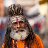

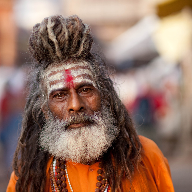

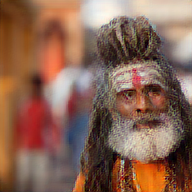

In [8]:
o = data_train[89*4+2]
display(torchvision.transforms.ToPILImage()(o[0]))
display(torchvision.transforms.ToPILImage()(o[1]))
trainer.display_result(data_train, 89*4+2)

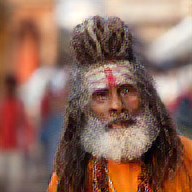

In [16]:
trainer.display_result(data_train, 89*4+2)

In [21]:
data_test = DIV2KEval(FOLDER_HR_TRAIN, 2)

trainer.display_result(data_test, 89*4+2)

In [560]:
import pandas as pd

df = pd.read_csv('hr_dims.csv')
df.head()

,2040,1404
0,2040,1848
1,2040,1356
2,2040,1344
3,1608,2040
4,1356,2040


In [580]:
mins = df.min(axis=1)
df.min()

2040    1116
1404     648
dtype: int64

<Axes: >

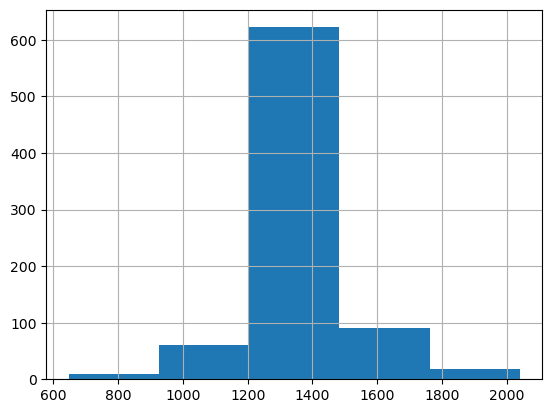

In [579]:
mins.hist(bins=5)

In [ ]:
trainer()